In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import ticker
import seaborn as sns

from alive_progress import alive_bar

from scipy.interpolate import interp1d
from scipy.stats import gaussian_kde
from scipy.optimize import curve_fit

from astropy.time import Time
import astropy.units as u

from datetime import datetime

import ssa_calc


plt.style.use("default")  # Dark background for plots

mpl.rcParams["grid.color"] = "grey"  # Grid color
mpl.rcParams["grid.linestyle"] = "--"  # Grid line style
mpl.rcParams["grid.linewidth"] = 0.5  # Grid line width
mpl.rcParams["grid.alpha"] = 0.5  # Grid transparency

# Setting plt colors:
# Setting plt colors to TU Delft colors (order: blue, red, yellow, green and repeating with different shades):
plt_colors = [
    "#006EB7",
    '#A50034',
    "#64A600",
    "#F97306",
    # Darker colors
    '#1A356E',
    "#E60000",
    '#6CC24A',
    '#FFB81C',
    # More darker colors
    "#000D3A",
    "#9A0000",
    "#B14400",
    "#3D5B00",
]

2023-06-04 14:59:05.286074: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-04 14:59:06.696918: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-06-04 14:59:06.697072: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2023-06-04 14:59:06.697089: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nv

In [2]:
# Loading the data
telem_path = r"../telemetry-files/delfi-pq/delfi-pq-telemetry-2022-01-18-to-2023-02-01.h5"
telem_df = pd.read_hdf(
    telem_path,
    "telem",
)

# Adding illumination to the dataframe:
for i, row in telem_df.iterrows():
    telem_df.loc[i, "illumination"] = 1 if row["theta_T (deg)"] < 360 * (1 - row["fe"]) else 0

telem_df["illumination"] = telem_df["illumination"].astype(np.int64)
# Rearranging illumination column to be after theta_T (deg):
cols = telem_df.columns.tolist()
cols = cols[:6] + cols[-1:] + cols[6:-1]
telem_df = telem_df[cols]
telem_df.head()

time (utc)     time (jd)  beta (deg)        fe  theta (deg)  \
0  2022-01-18 17:12:17.000  2.459598e+06   32.895989  0.349273   220.506984   
1  2022-01-18 18:41:24.000  2.459598e+06   32.900397  0.349014   197.714357   
2  2022-01-18 18:43:24.000  2.459598e+06   32.901143  0.349090   205.275916   
3  2022-01-18 18:44:24.000  2.459598e+06   32.901391  0.349131   209.056697   
4  2022-01-18 18:45:24.000  2.459598e+06   32.901552  0.349173   212.837490   

   theta_T (deg)  illumination  battery GG temperature (deg C)  \
0     337.637846             0                            -4.2   
1     314.891798             0                            -0.7   
2     322.439748             0                            -1.9   
3     326.213181             0                            -2.4   
4     329.986271             0                            -3.0   

   battery TMP20 temperature (deg C)  solar panel Yp temperature (deg C)  \
0                               -3.2                               -24.7   
1                                0.8                               -18.5   
2                                0.0                               -20.9   
3                               -0.2                               -21.9   
4                               -1.3                               -23.0   

   solar panel Ym temperature (deg C)  solar panel Xp temperature (deg C)  \
0                               -26.4                               -25.0   
1                               -20.7                               -18.6   
2                               -22.7                               -20.8   
3                               -23.8                               -22.1   
4                               -24.9                               -23.2   

   solar panel Xm temperature (deg C)  MCU temperature (deg C)  
0                               -23.4                    -12.2  
1                               -17.8                     -7.4  
2                               -19.9                     -8.9  
3                               -20.9                     -9.8  
4                               -21.9                    -11.2

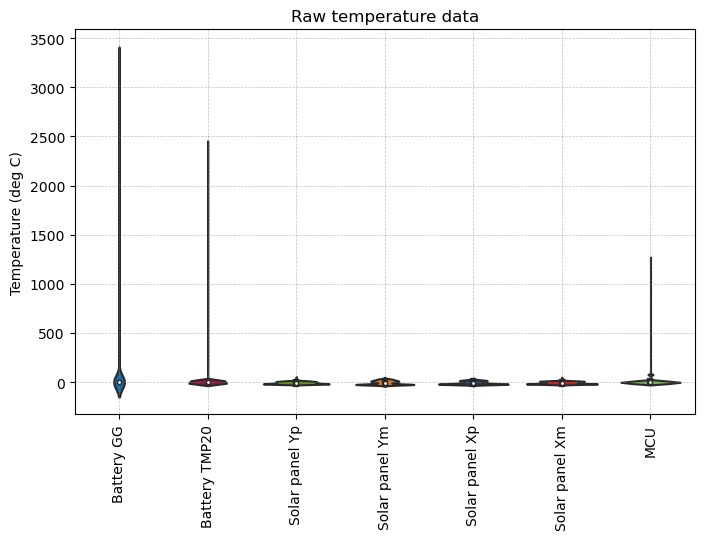

In [3]:
# Plotting the temperature data in a violin plot:
fig, ax = plt.subplots(figsize=(8, 5))
ax = sns.violinplot(
    data=telem_df.loc[:, "battery GG temperature (deg C)":"MCU temperature (deg C)"],
    palette=plt_colors,
    ax=ax,
)
ax.set_xticklabels(
    [
        "Battery GG",
        "Battery TMP20",
        "Solar panel Yp",
        "Solar panel Ym",
        "Solar panel Xp",
        "Solar panel Xm",
        "MCU",
    ],
    rotation=90,
    ha="center",
)
ax.set_ylabel("Temperature (deg C)")
ax.set_title("Raw temperature data")
ax.grid()
plt.show()

In [7]:
telem_path = r"../telemetry-files/delfi-pq/delfi-pq-telemetry-2022-01-18-to-2023-02-01.h5"
telem_raw_df = pd.read_hdf(
    telem_path,
    "telem",
)

In [8]:
def hampel_filter(data):
    data = data.copy()
    median = np.median(data)
    MAD = np.median(np.abs(data - median))
    HI = (data - median) / (1.4826 * MAD)
    data[HI > 3] = np.nan
    
    return data

In [9]:
telem_df = telem_raw_df.copy(deep=True)
for i, row in telem_df.iterrows():
    for j, item in row.iloc[6:].items():
        if not -40 < item < 70:
            telem_df.loc[i, j] = np.nan
            
telem_df = telem_df.dropna(how="any")

In [11]:

theta_T_window = 5
min_data = 7
telem_processed_df = telem_df.copy(deep=True).reset_index(drop=True)
theta_T_bins = np.arange(0, 360, theta_T_window)
theta_T = telem_processed_df["theta_T (deg)"].to_numpy()

for i in range(7):
    raw_temps = telem_processed_df.iloc[:, 6+i].to_numpy()
    cleaned_temps = raw_temps.copy()
    for theta_T_bin in theta_T_bins:
        idxs = np.where((theta_T >= theta_T_bin) & (theta_T < theta_T_bin + theta_T_window))[0]
        temps = raw_temps[idxs]
        if temps.shape[0] < min_data:
            temps[:] = np.nan
        else:
            temps = hampel_filter(temps)
        cleaned_temps[idxs] = temps
        
    telem_processed_df.iloc[:, 6+i] = cleaned_temps
    

# Get indexes of rows containing NaNs
nan_idxs = telem_processed_df.index[telem_processed_df.isna().any(axis=1)].tolist()
print(telem_processed_df.shape)
# Drop rows containing NaNs and the corresponding illumination data
telem_processed_df = telem_processed_df.dropna(how="any")


print(telem_processed_df.shape)


(2487, 13)
(2109, 13)


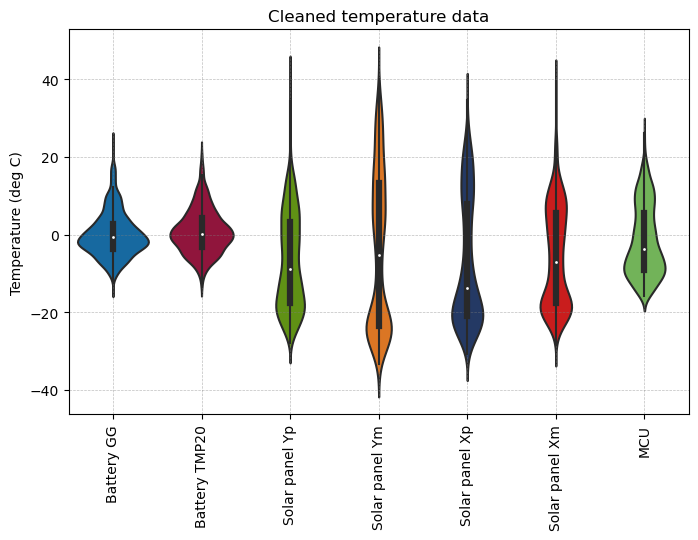

In [4]:
# Cleaning the data:

telem_processed_df = telem_df.copy()

for i, row in telem_processed_df.iterrows():
    # Removing temperatures if 200 < theta_T < 250:
    if 200 < row["theta_T (deg)"] < 250:
        telem_processed_df.loc[i, :] = np.nan
    # Removing temperature if > 50 deg C:
    for j, temp in row.iloc[6:].items():
        if temp > 50:
            telem_processed_df.loc[i, j] = np.nan

telem_processed_df = telem_processed_df.dropna(how="any").reset_index(drop=True)

# Plotting the temperature data in a violin plot:
fig, ax = plt.subplots(figsize=(8, 5))
ax = sns.violinplot(
    data=telem_processed_df.loc[:, "battery GG temperature (deg C)":"MCU temperature (deg C)"],
    palette=plt_colors,
    ax=ax,
)
ax.set_xticklabels(
    [
        "Battery GG",
        "Battery TMP20",
        "Solar panel Yp",
        "Solar panel Ym",
        "Solar panel Xp",
        "Solar panel Xm",
        "MCU",
    ],
    rotation=90,
    ha="center",
)
ax.set_ylabel("Temperature (deg C)")
ax.set_title("Cleaned temperature data")
ax.grid()
plt.show()


In [5]:
def plot_model(theta_T_vals, temp_vals, plt_titles=None, labels=None, colors=None, plt_scatter=None, linestyles=None, limits=None, plt_suptitle=None):
    """
    Function to plot the temperatures vs. theta_T.
    :param theta_T_vals: theta_T values.
    :param temp_vals: Temperature values.
    :param plt_titles: Titles of the plots.
    :param labels: Labels of the plots.
    :param colors: Colors of the plots.
    :param plt_scatter: Whether to plot the data as a scatter plot or not.
    :param linestyles: Linestyles of the plots.
    :param limits: Limits of the temperature data.

    :return: None
    """
    plt_rows = 2
    plt_cols = 3
    
    fig, ax = plt.subplots(plt_rows, plt_cols, figsize=(plt_cols * 5, plt_rows * 5))

    for i in range(plt_rows):
        for j in range(plt_cols):
            for k in range(len(theta_T_vals)):
                if plt_scatter[k]:
                    ax[i, j].scatter(
                        theta_T_vals[k],
                        temp_vals[k][:, i * plt_cols + j],
                        label=labels[k] if labels is not None else None,
                        color=colors[k] if colors is not None else plt_colors[k],
                        s=2,
                    )
                else:
                    ax[i, j].plot(
                        theta_T_vals[k],
                        temp_vals[k][:, i * plt_cols + j],
                        label=labels[k] if labels is not None else None,
                        color=colors[k] if colors is not None else plt_colors[k],
                        linestyle=linestyles[k] if linestyles is not None else "-",
                    )
            
            ax[i, j].set_xlabel(r"$\theta_T$ (deg)")
            ax[i, j].set_ylabel("Temperature (deg C)")
            ax[i, j].set_title(plt_titles[i * plt_cols + j] if plt_titles is not None else None)
            ax[i, j].legend(fontsize=8)
            ax[i, j].set_xlim([0, 360])
            if limits is not None:
                ax[i, j].set_ylim(limits)
            ax[i, j].grid()

    if plt_suptitle is not None:
        fig.suptitle(plt_suptitle, fontsize=12)

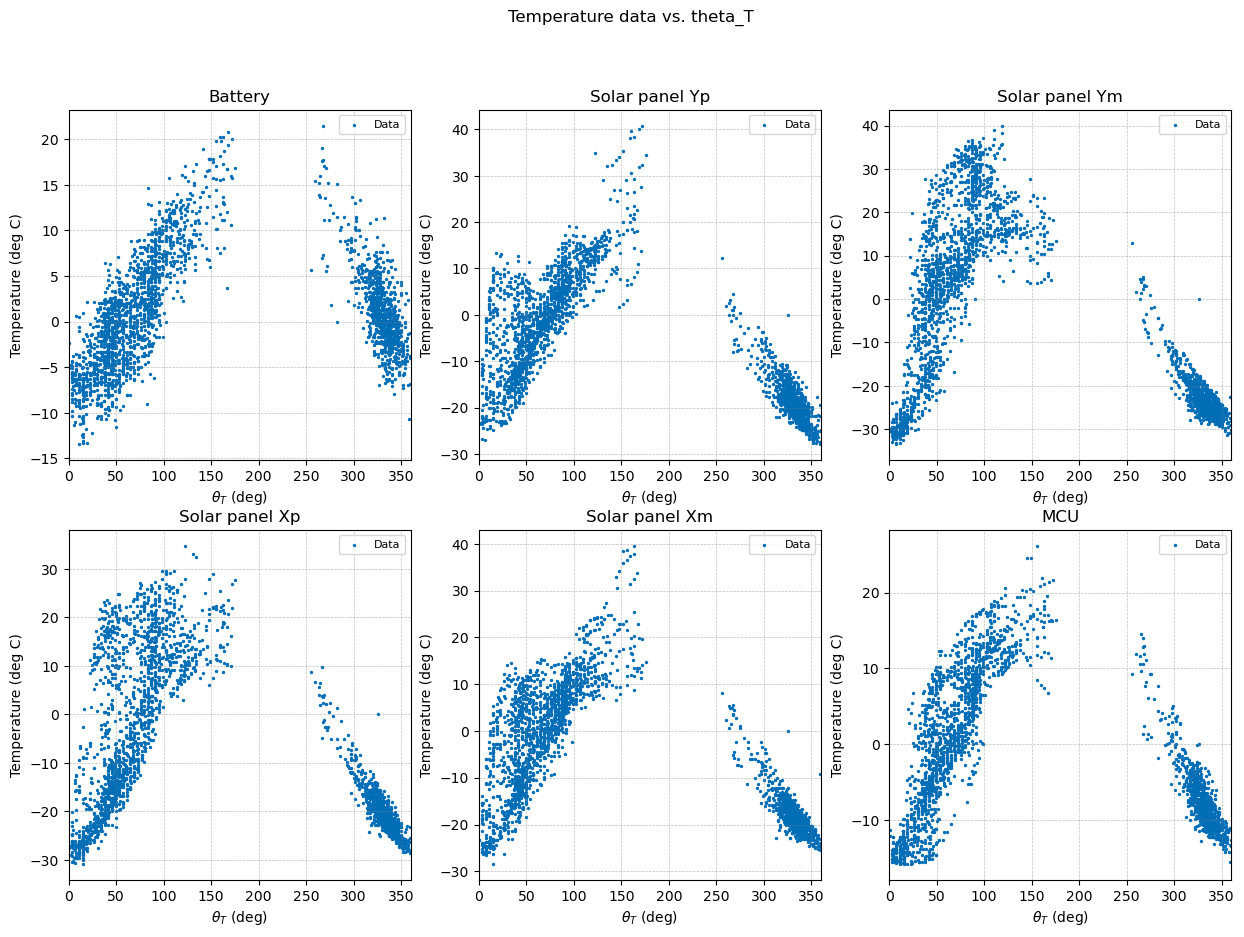

In [6]:
# Plotting the temperature data vs. theta_T:
plot_model(
    [telem_processed_df["theta_T (deg)"].to_numpy()],
    [telem_processed_df.iloc[:, -6:].to_numpy()],
    plt_titles=[
        "Battery",
        "Solar panel Yp",
        "Solar panel Ym",
        "Solar panel Xp",
        "Solar panel Xm",
        "MCU",
    ],
    plt_scatter=[True],
    labels=["Data"],
    plt_suptitle="Temperature data vs. theta_T",
)

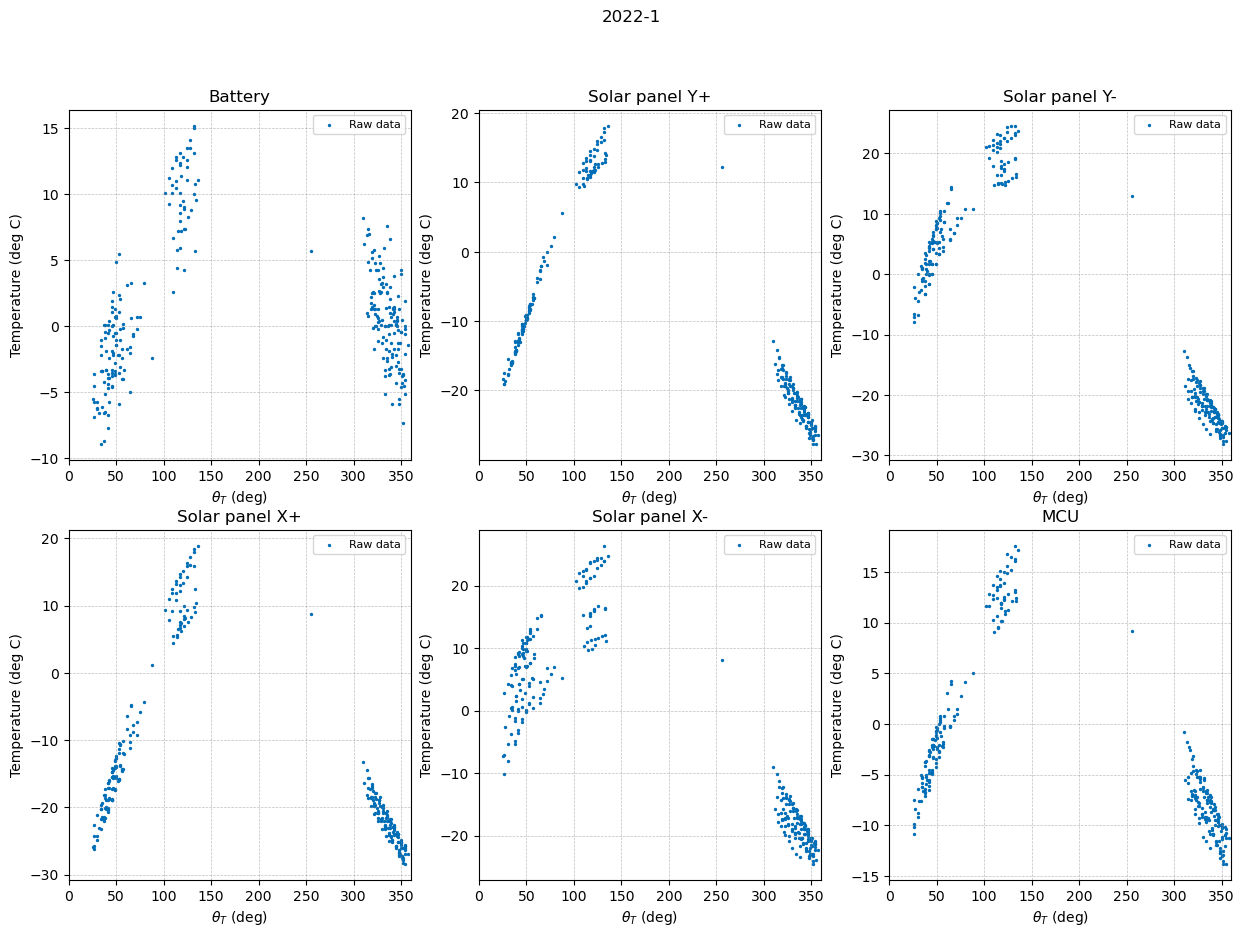

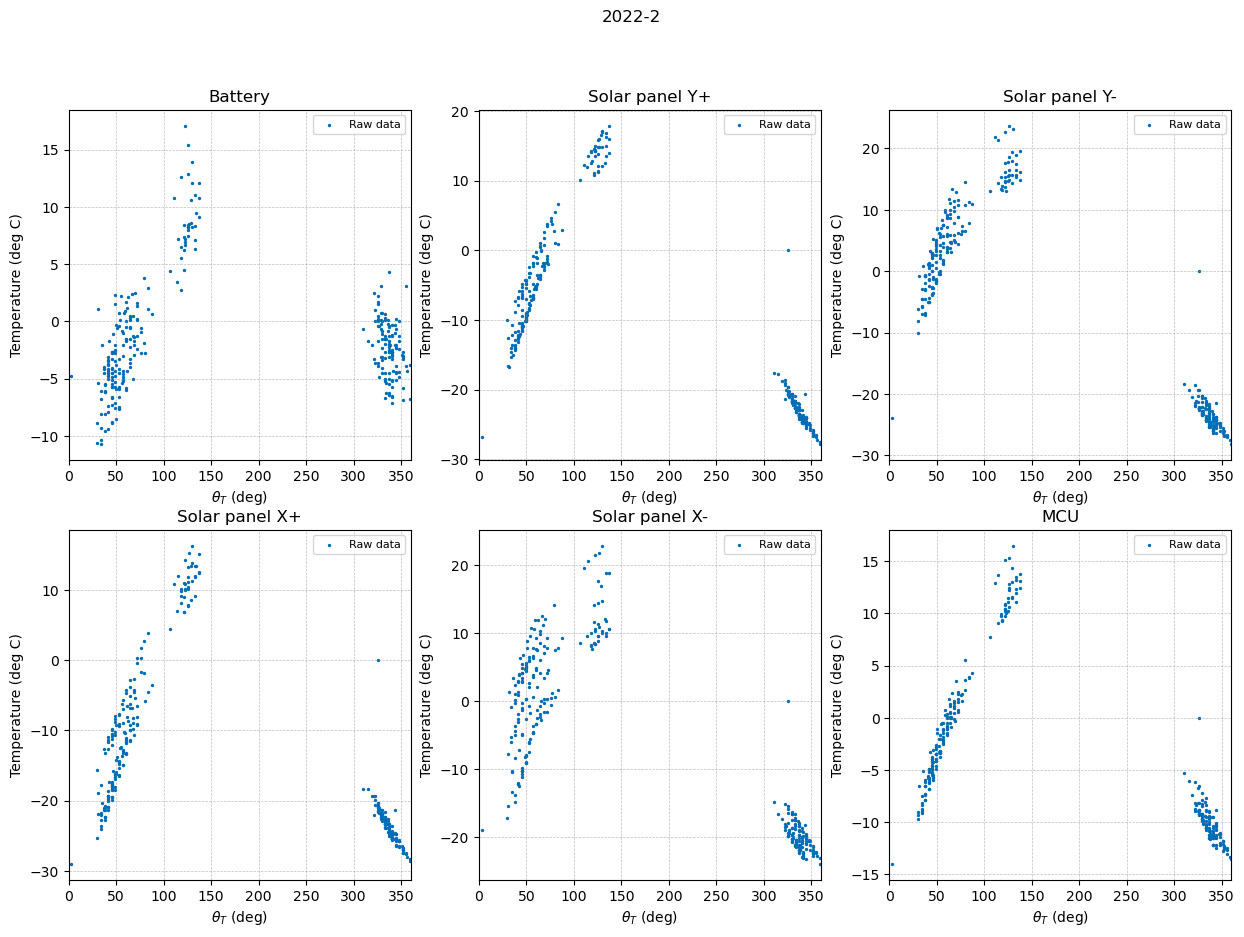

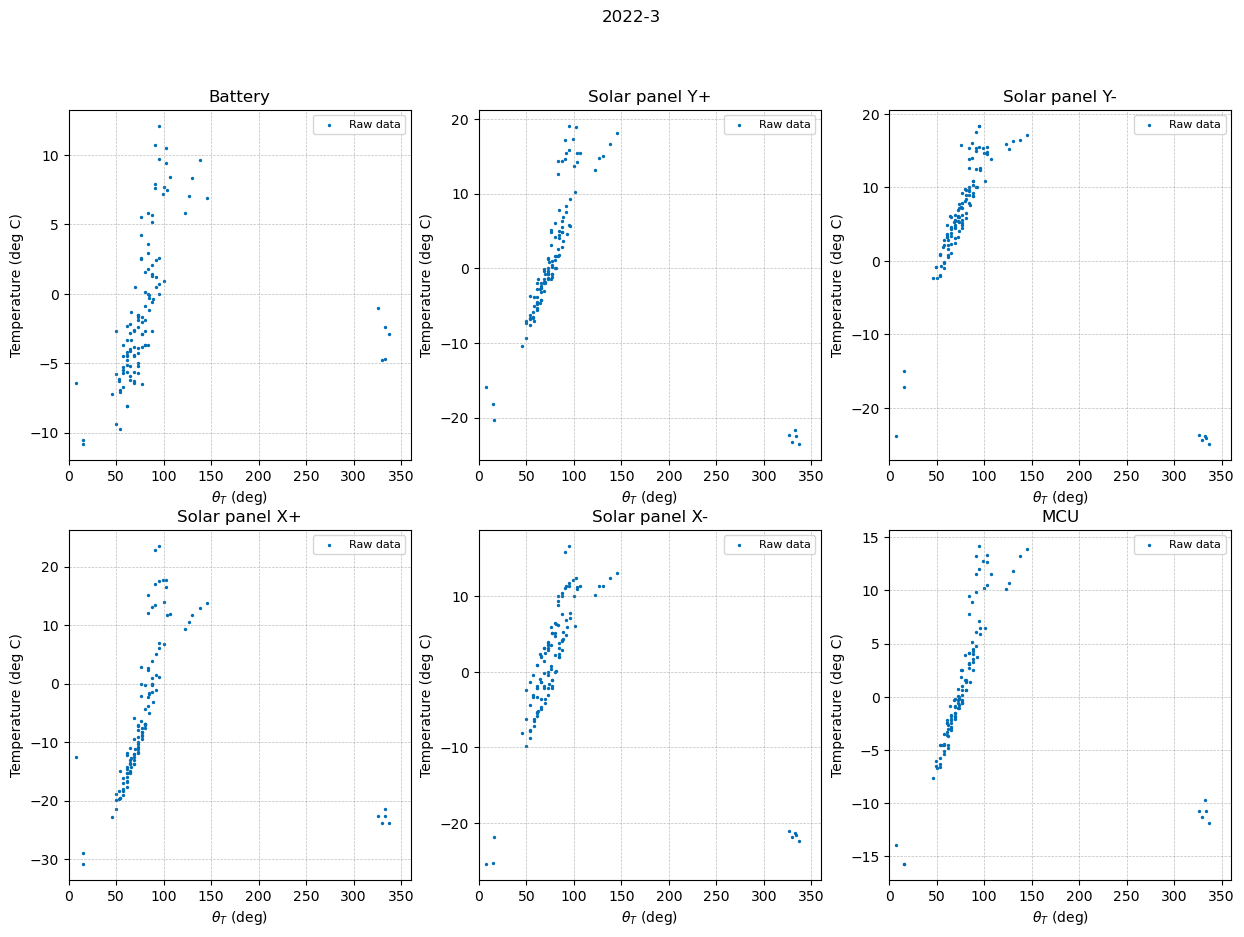

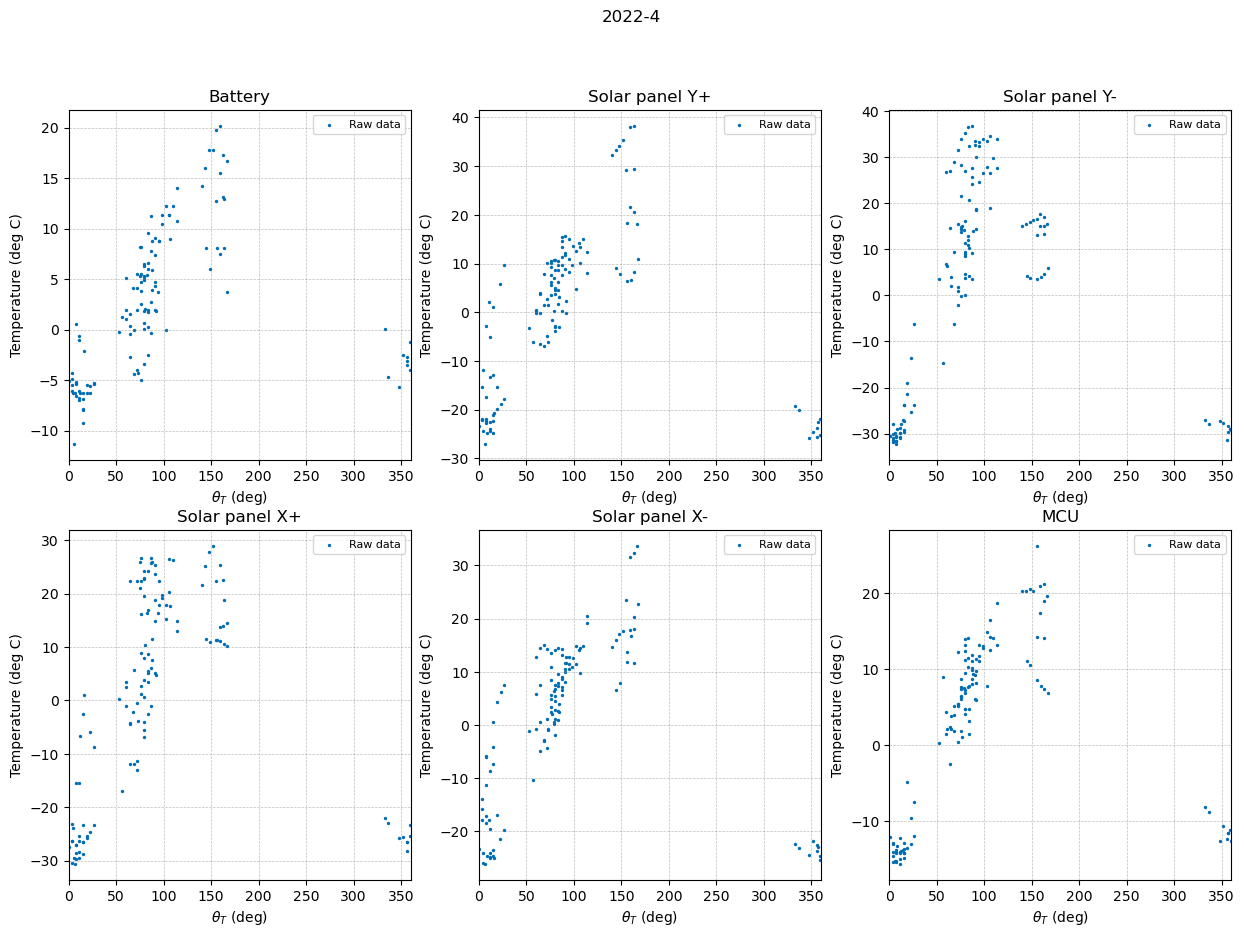

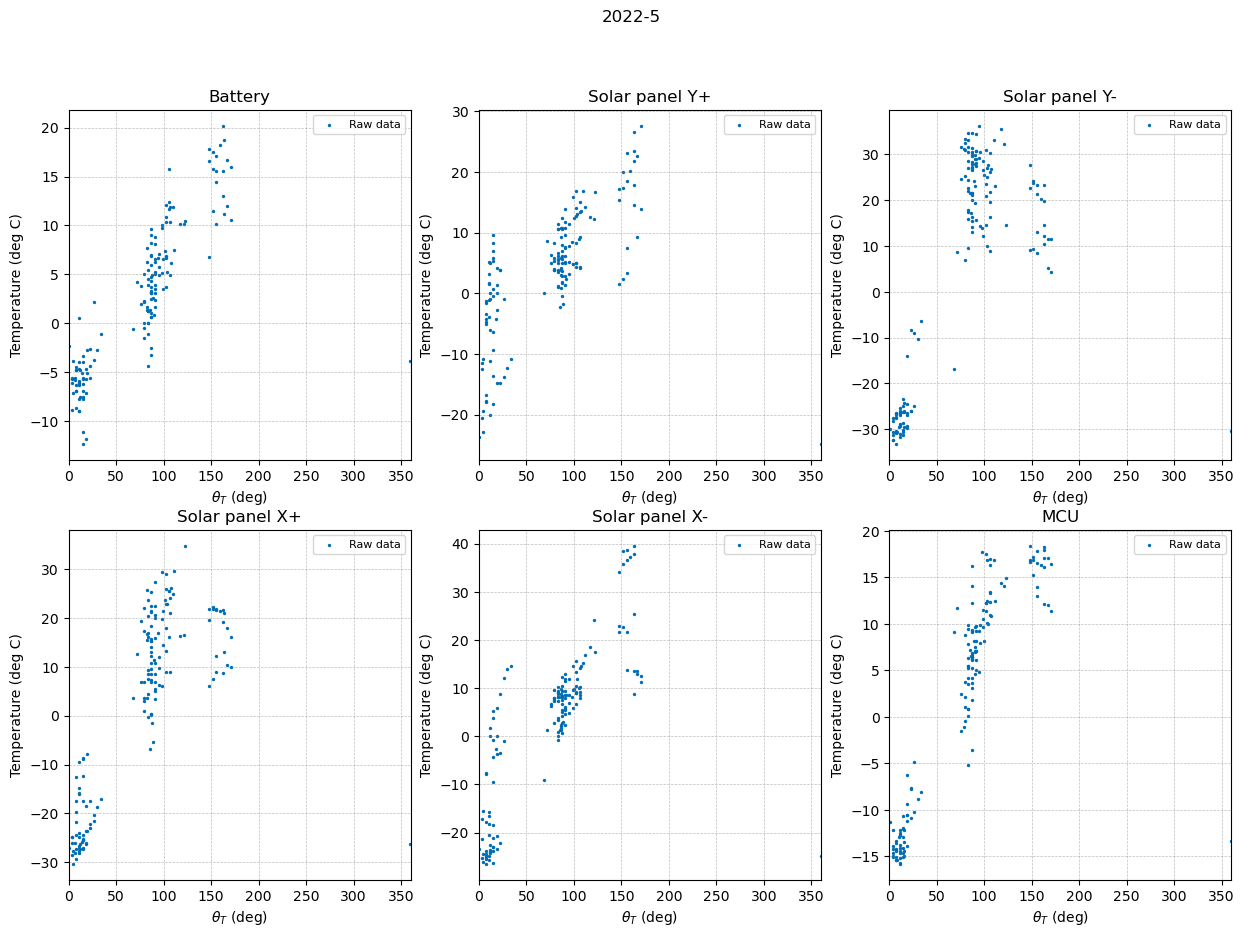

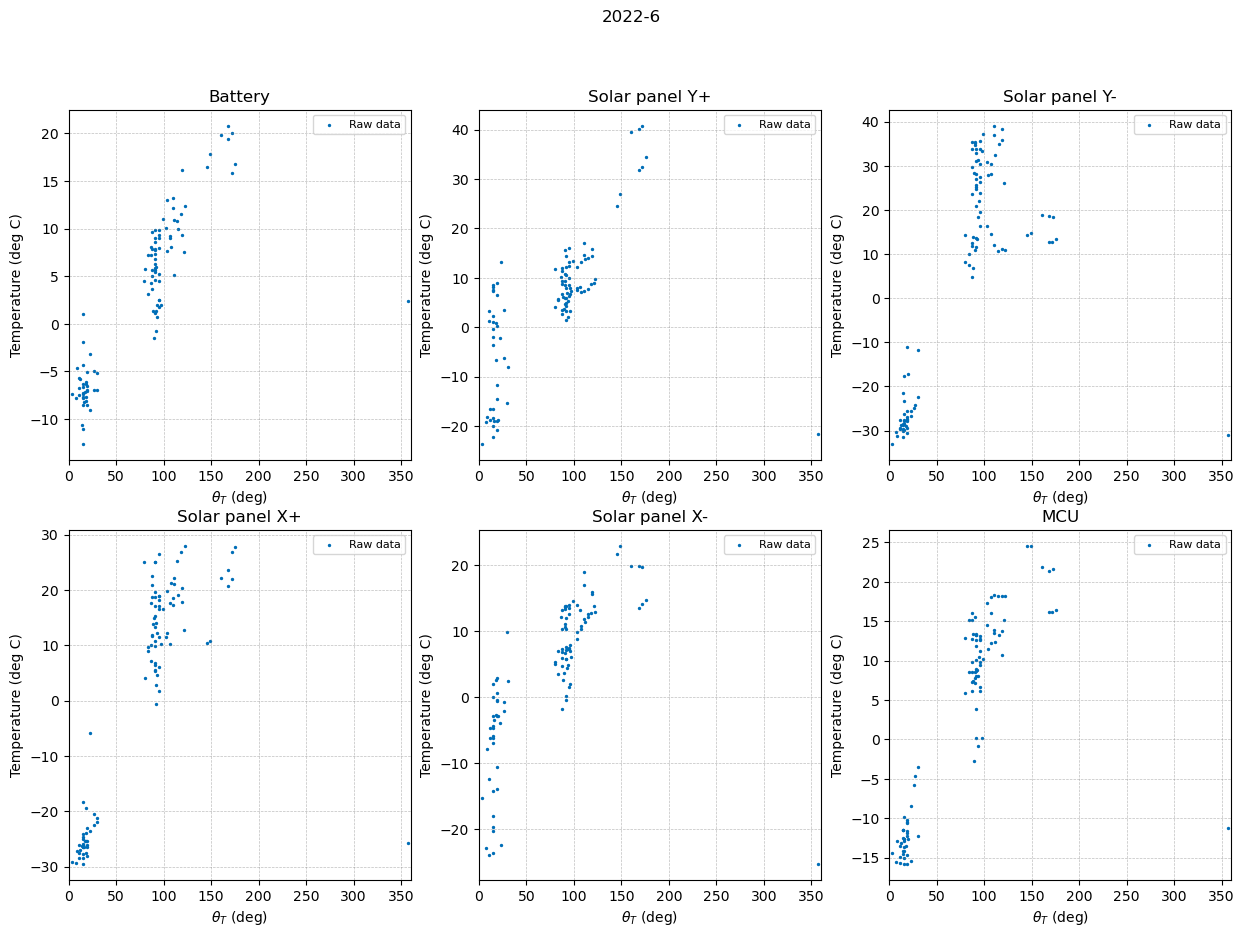

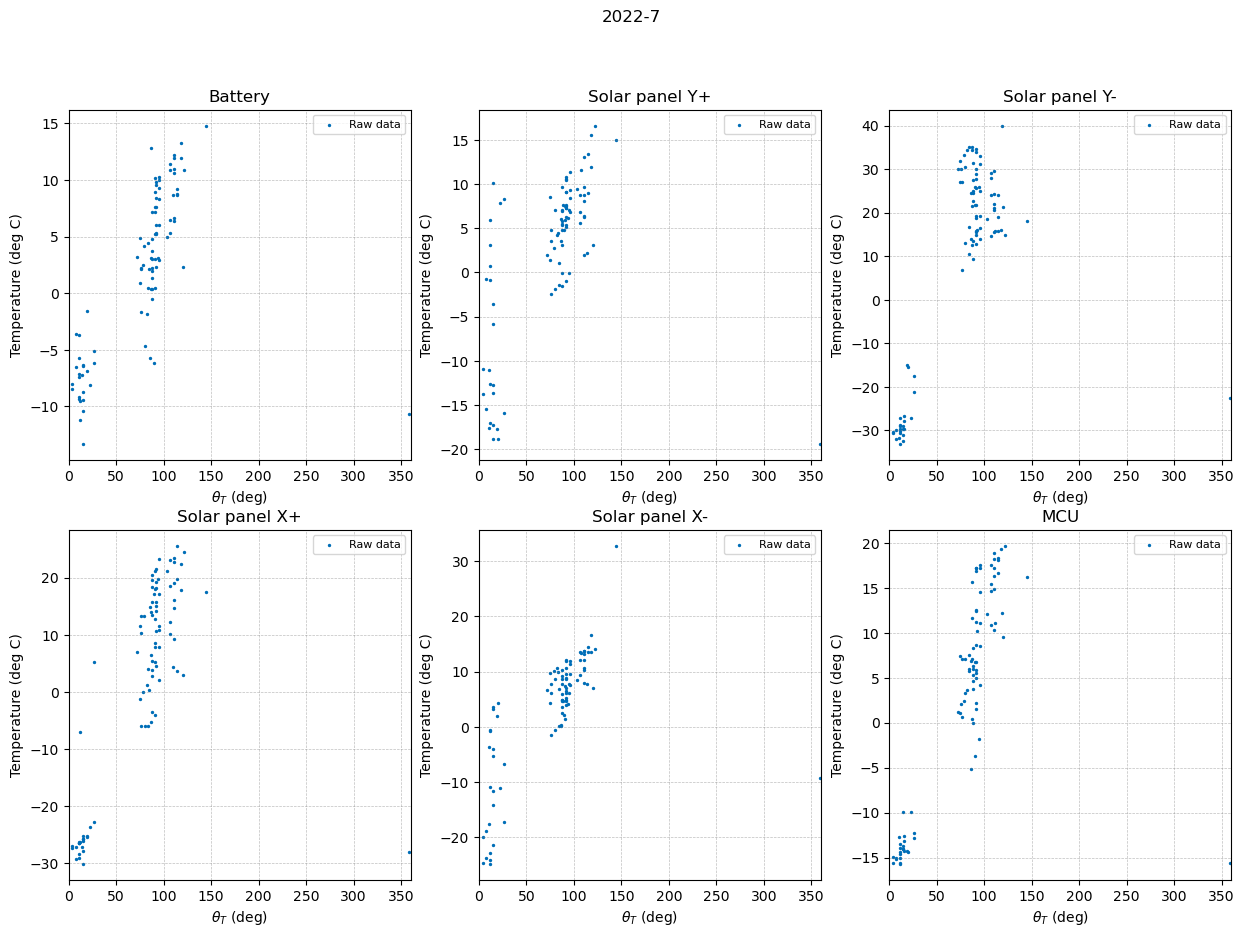

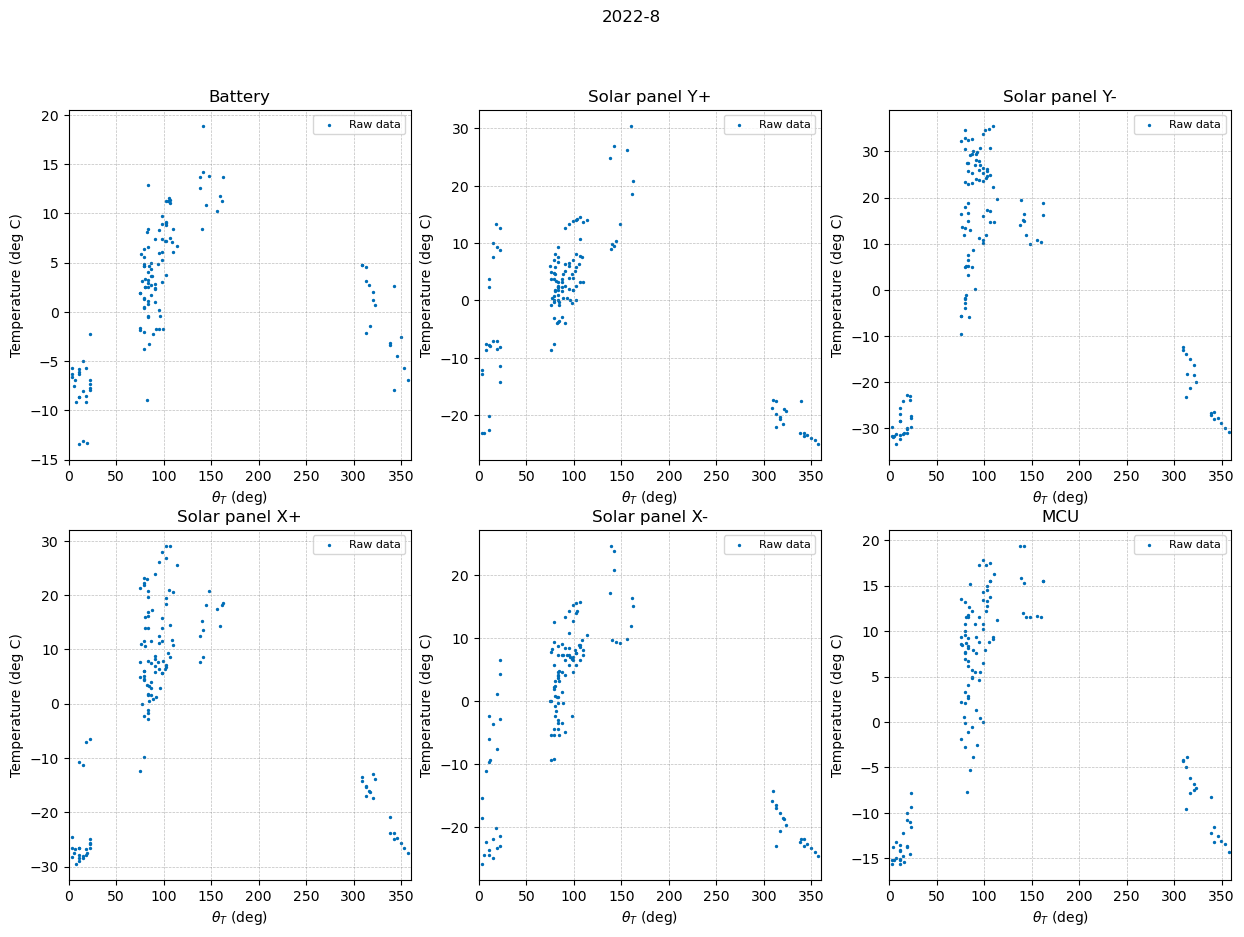

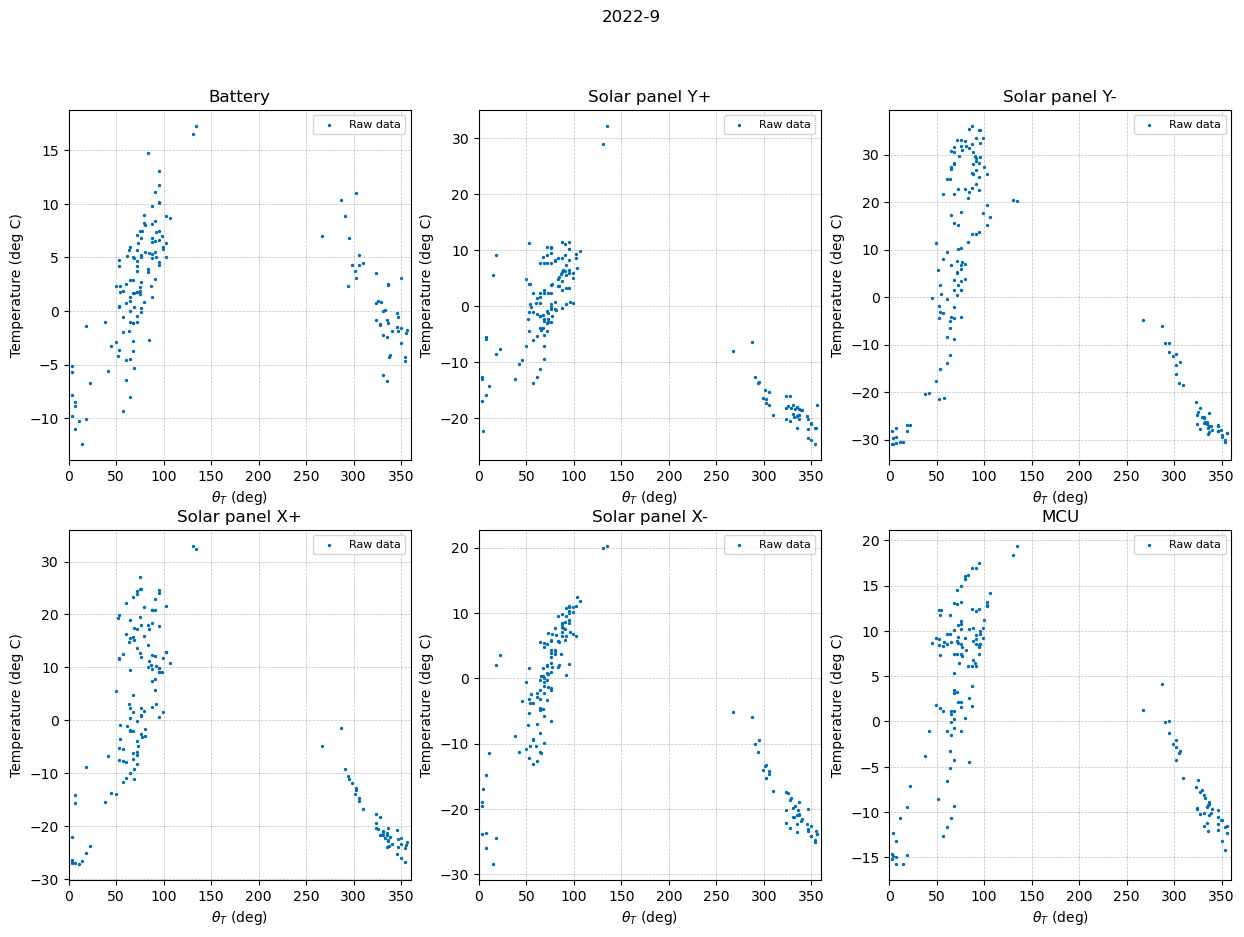

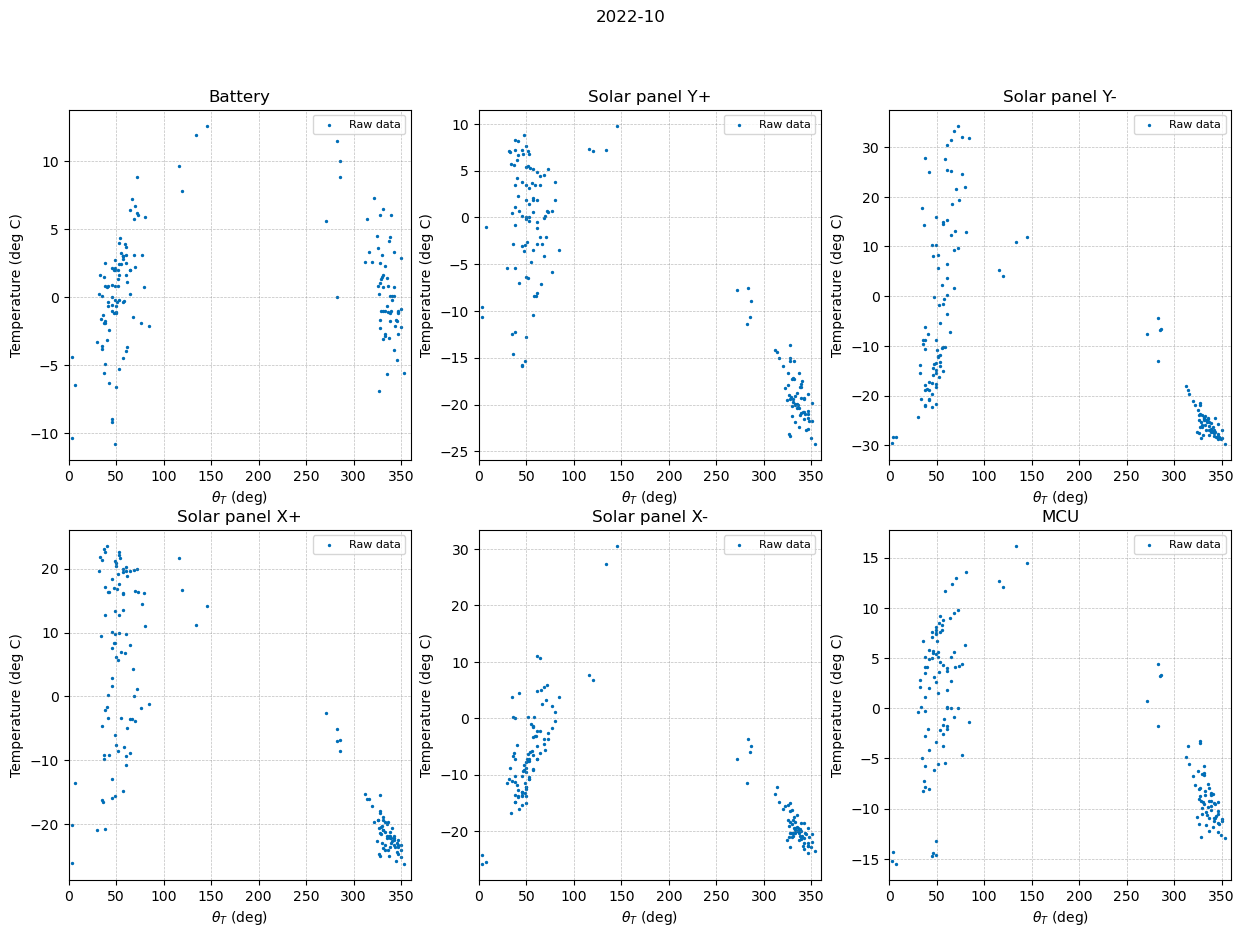

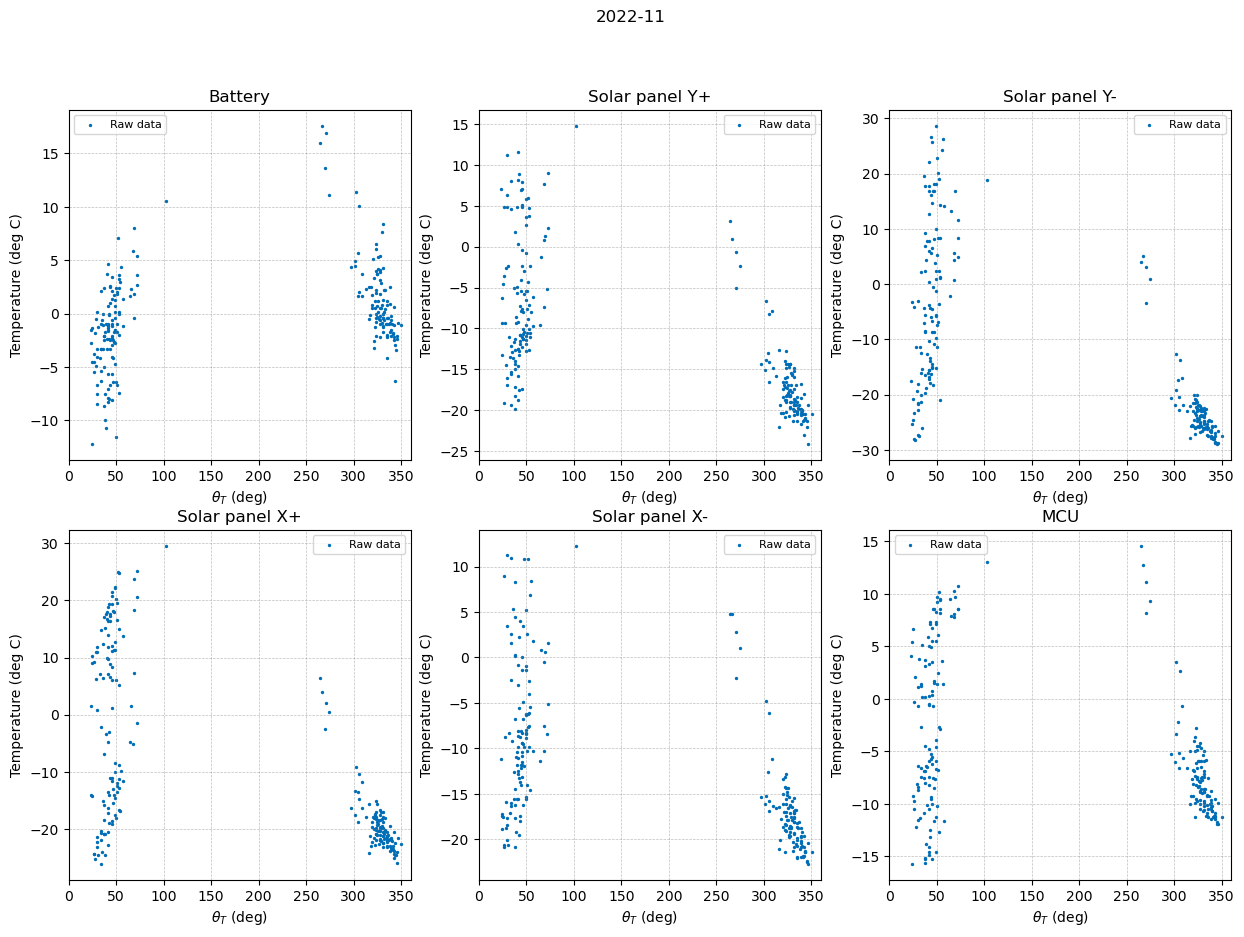

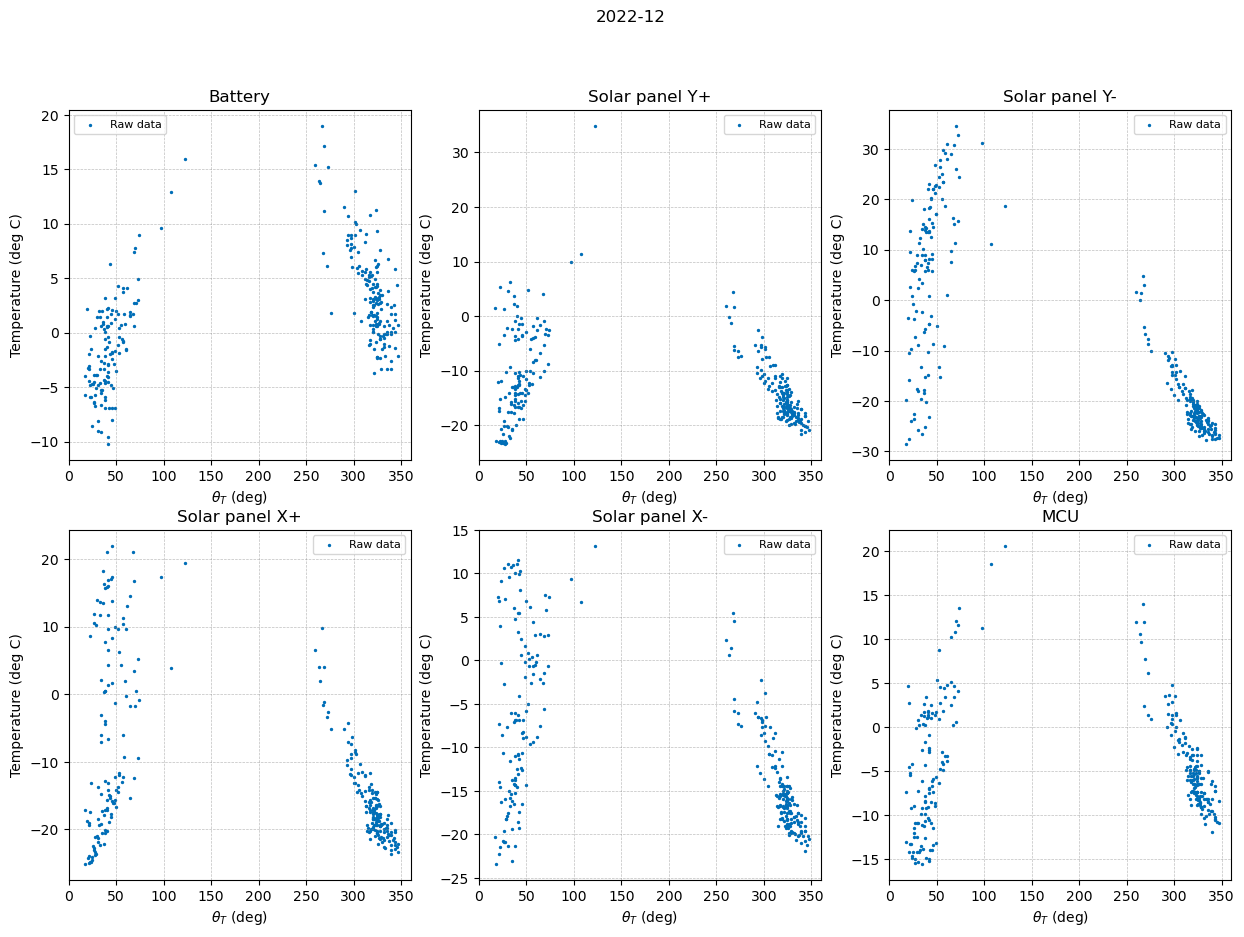

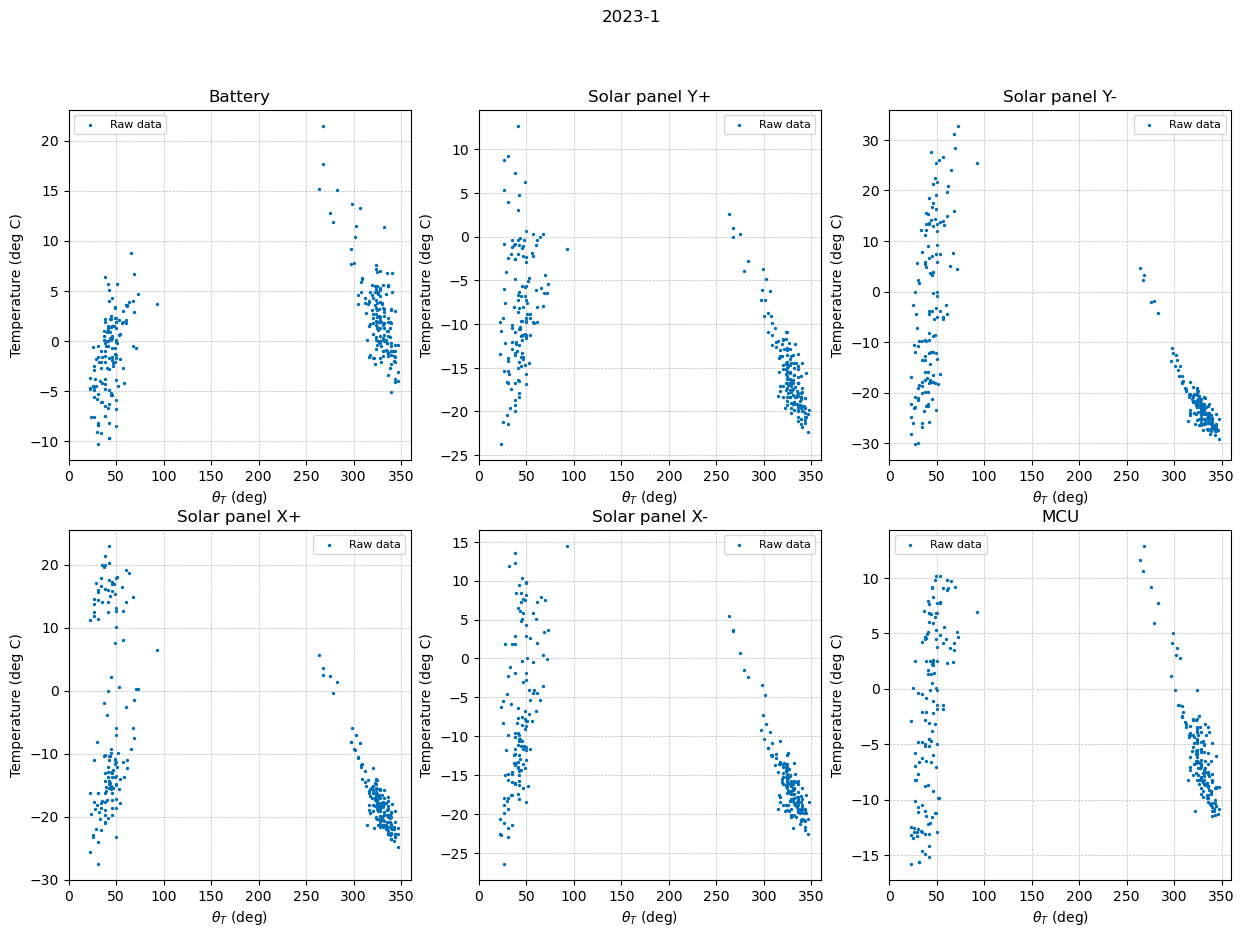

In [7]:
# Plotting the temperatures vs. theta_T for each month:
start_time = Time(telem_processed_df["time (utc)"][0], format="iso", scale="utc").to_datetime()
start_idx = 0
for i, row in telem_processed_df.iterrows():
    curr_time = Time(row["time (utc)"], format="iso", scale="utc").to_datetime()
    if curr_time.month != start_time.month:
        plot_model(
            [telem_processed_df["theta_T (deg)"][start_idx:i].to_numpy()],
            [telem_processed_df.iloc[start_idx:i, -6:].to_numpy()],
            plt_titles=[
                "Battery",
                "Solar panel Y+",
                "Solar panel Y-",
                "Solar panel X+",
                "Solar panel X-",
                "MCU",
            ],
            labels=["Raw data"],
            plt_scatter=[True],
            plt_suptitle=f"{start_time.year}-{start_time.month}",
        )

        start_time = curr_time
        start_idx = i

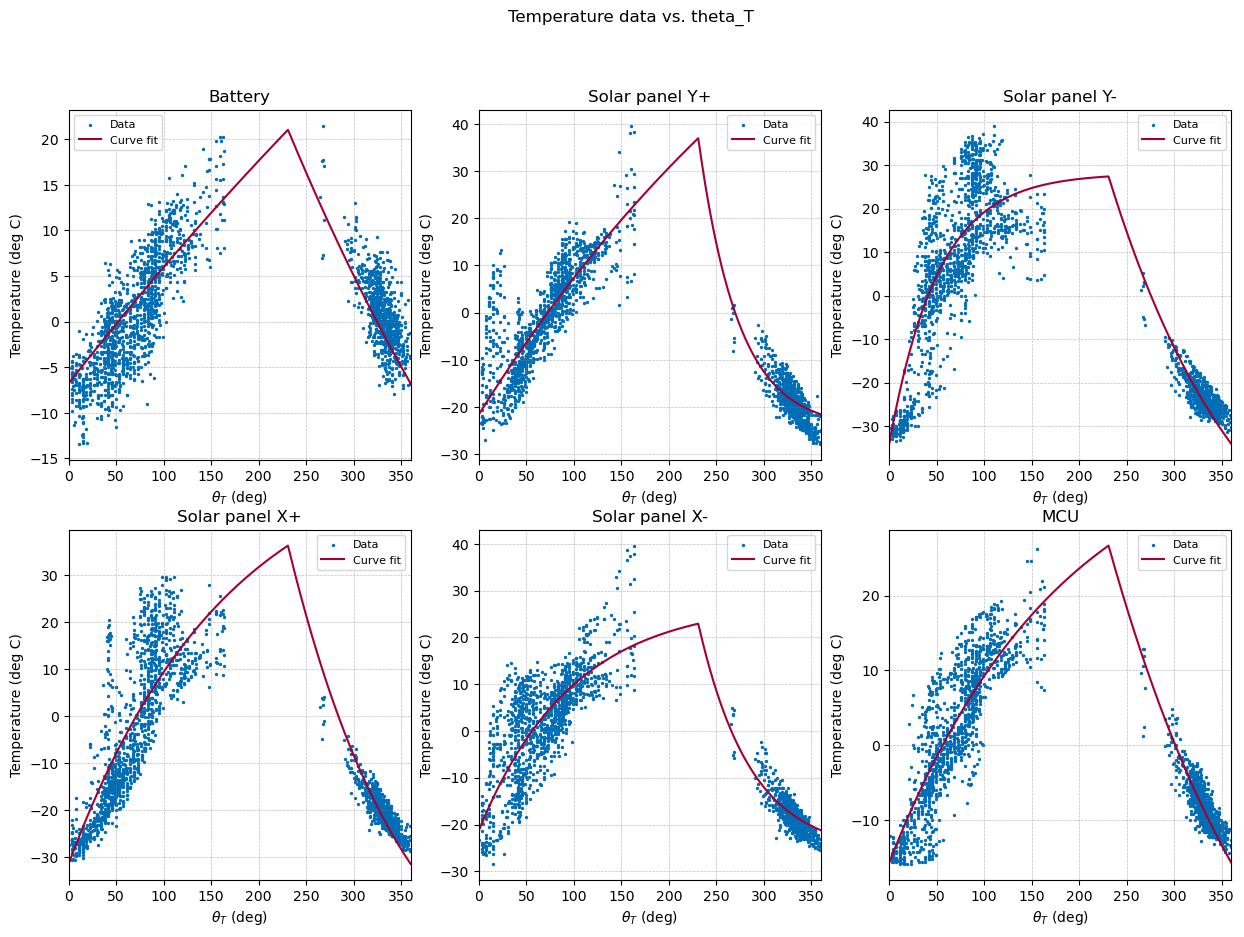

In [15]:
# Curve fit 
# Exponential fit on the temperature data with the following conditions:
#   - The temperature at theta_T = 0 and theta_T = 360 is the same
#   - The temperature at the end of the heating phase is the same as the temperature at the beginning of the cooling phase

fe_mean = np.mean(telem_df["fe"])   # Mean fe for the data
theta_E = 360 * (1 - fe_mean)       # Mean theta_E for the data

def fit_function(theta_T, T_sat_rising, r_rising, T_0, dT_0_falling):
    """
    Function to fit to the temperature data.
    :param theta_T: Array of theta_T values
    :param T_sat_rising: Saturation temperature of the heating phase
    :param r_rising: Rate of temperature rise during heating phase
    :param T_0: Temperature at theta_T = 0
    :param dT_0_falling: delta T between T_0 and saturation temperature of cooling phase
    """
    T_E = T_sat_rising * (1 - np.exp(-r_rising * theta_E)) + T_0    # Temperature at the beginning of ecllipse

    T_sat_falling = T_0 - dT_0_falling  # Saturation cooling temperature at theta_T = inf

    # Determining rate of falling temperature to satisfy T_begin = T_end at theta_E = 0 and theta_E = 360
    r_falling = -np.log(dT_0_falling / (T_E - T_sat_falling)) / (360 - theta_E)

    return_array = np.empty(shape=theta_T.shape, dtype=np.float64)

    for i, theta_T_i in enumerate(theta_T):
        if theta_T_i < theta_E:
            return_array[i] = T_sat_rising * (1 - np.exp(-r_rising * theta_T_i)) + T_0
        else:
            return_array[i] = (T_E - T_sat_falling) * np.exp(-r_falling * (theta_T_i - theta_E)) + T_sat_falling

    return return_array


# Curve fit over the whole date:
fit_params = np.empty(shape=(6, 4), dtype=np.float64)

for i in range(6):
    popt, pcov = curve_fit(
        fit_function,
        telem_processed_df["theta_T (deg)"].to_numpy(),
        telem_processed_df.iloc[:, -6+i].to_numpy() + 273.15,
        p0=[25, 0.01, 300, 10],
        bounds=([0, 0, 200, 0.1], [150, 1, 350, 75]),
    )

    fit_params[i] = popt

# Plotting the curve fit:
theta_T_fit = np.linspace(0, 360, 500)
temp_fit = np.empty(shape=(theta_T_fit.shape[0], 6), dtype=np.float64)

for i in range(6):
    temp_fit[:, i] = fit_function(theta_T_fit, *fit_params[i]) - 273.15

plot_model(
    [telem_processed_df["theta_T (deg)"].to_numpy(), theta_T_fit],
    [telem_processed_df.iloc[:, -6:].to_numpy(), temp_fit],
    plt_titles=[
        "Battery",
        "Solar panel Y+",
        "Solar panel Y-",
        "Solar panel X+",
        "Solar panel X-",
        "MCU",
    ],
    labels=["Data", "Curve fit"],
    plt_scatter=[True, False],
    plt_suptitle="Temperature data vs. theta_T",
)

ValueError: `ydata` must not be empty!

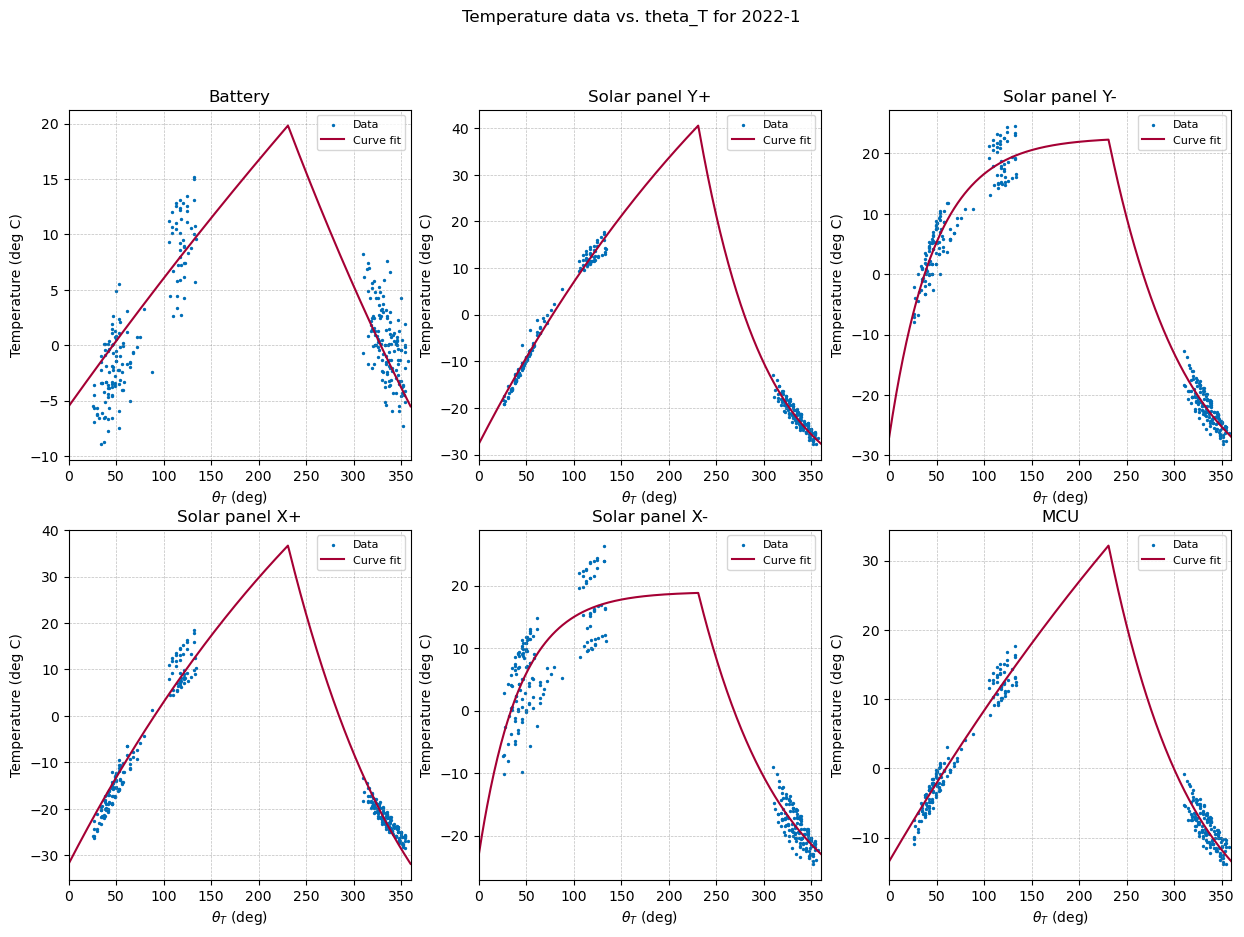

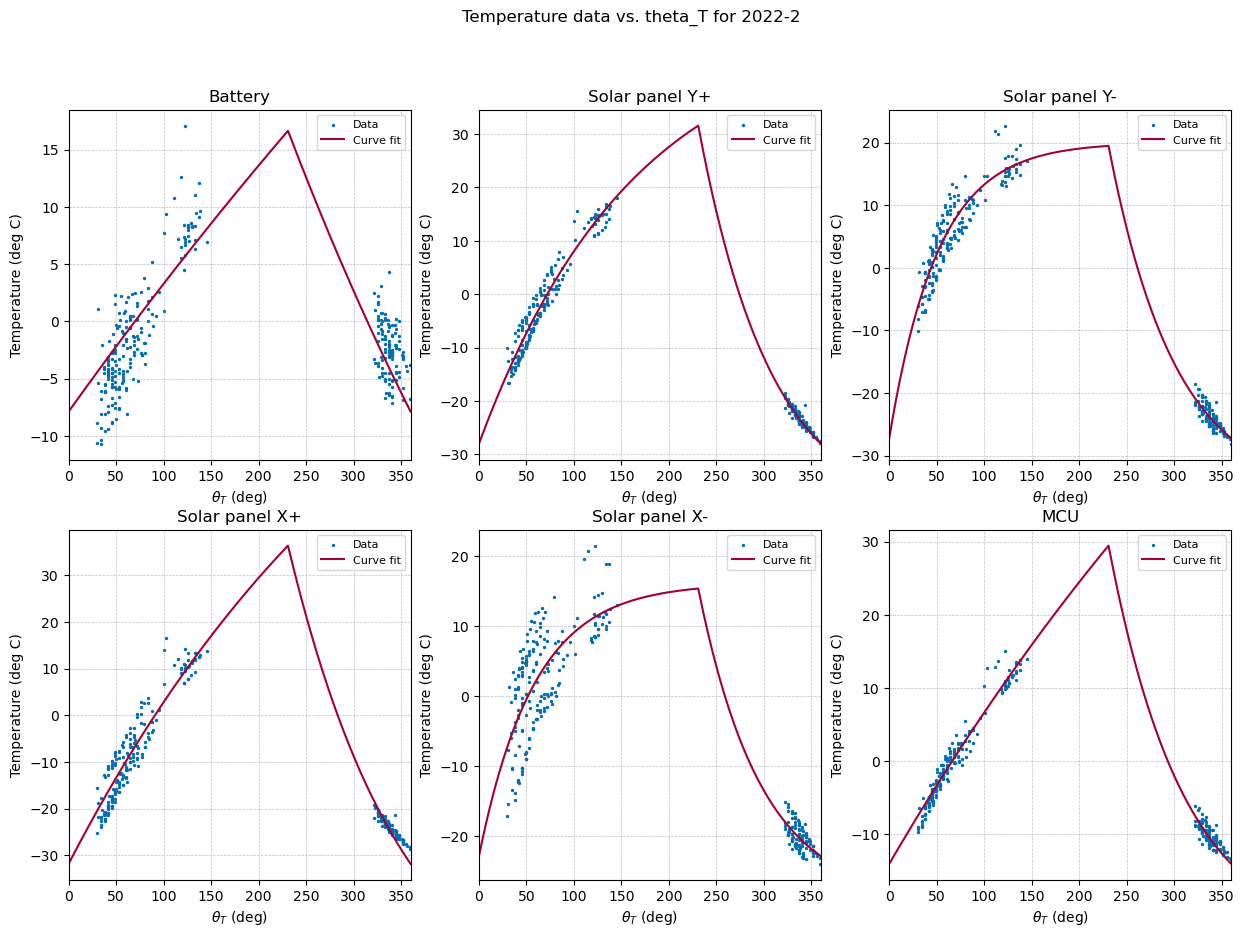

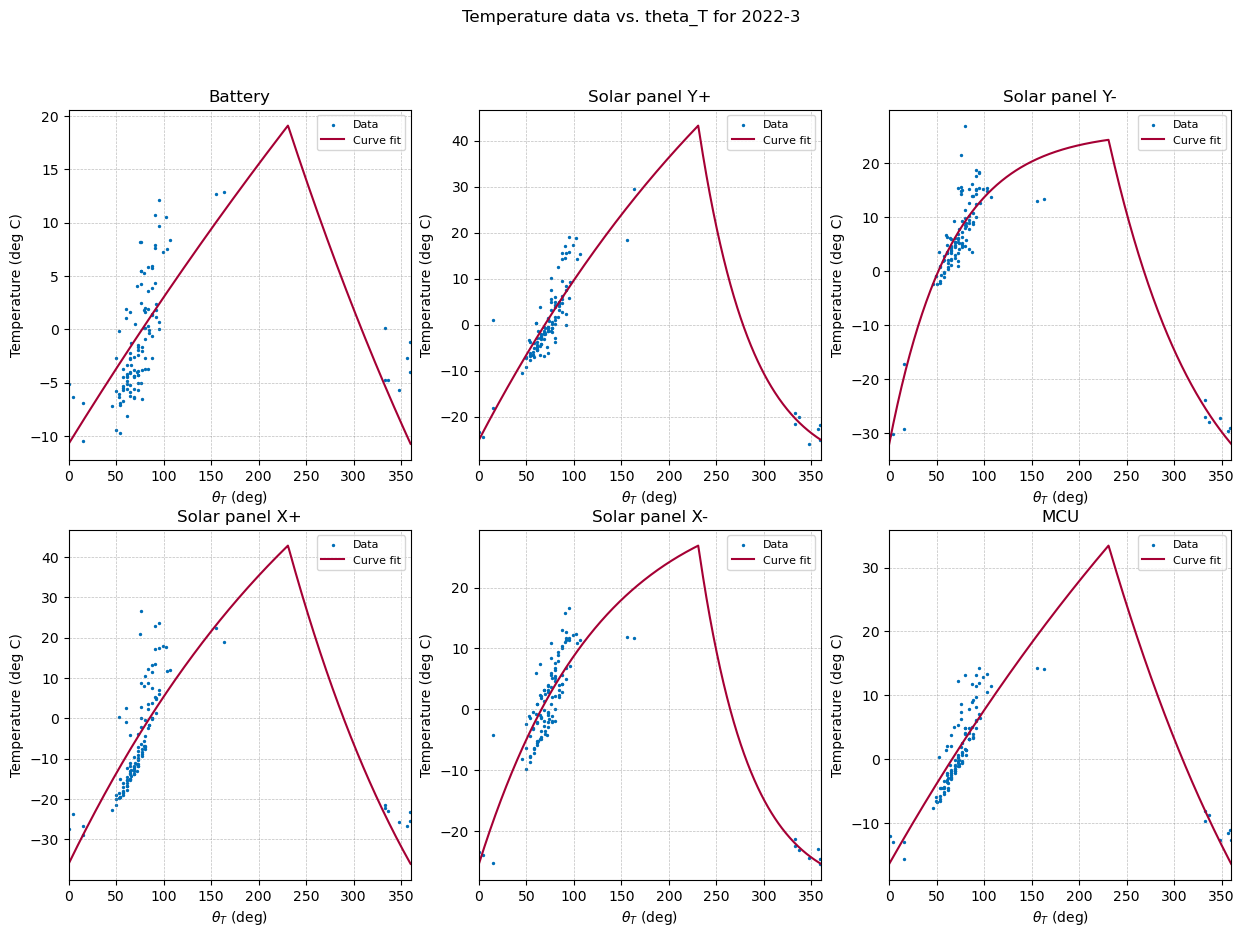

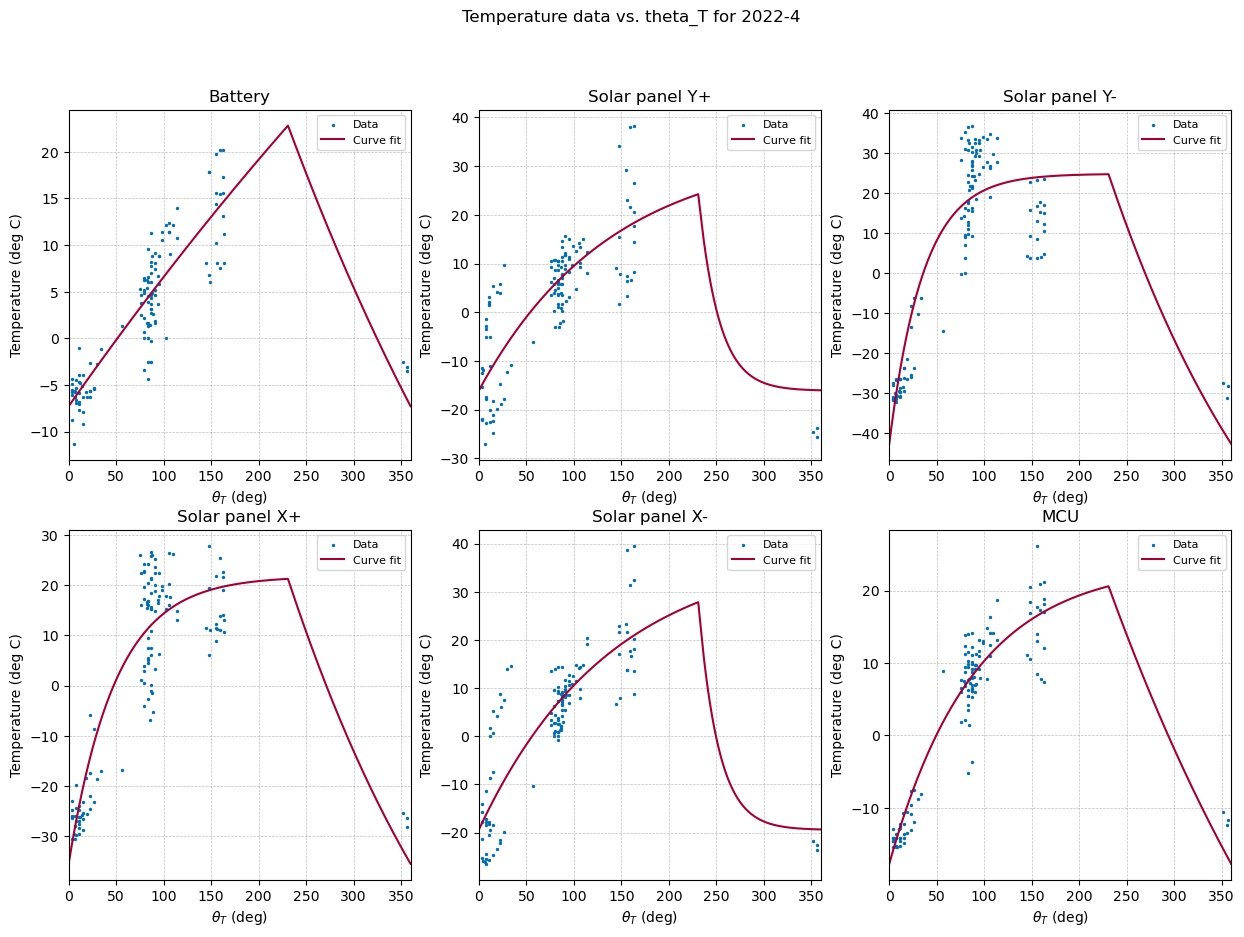

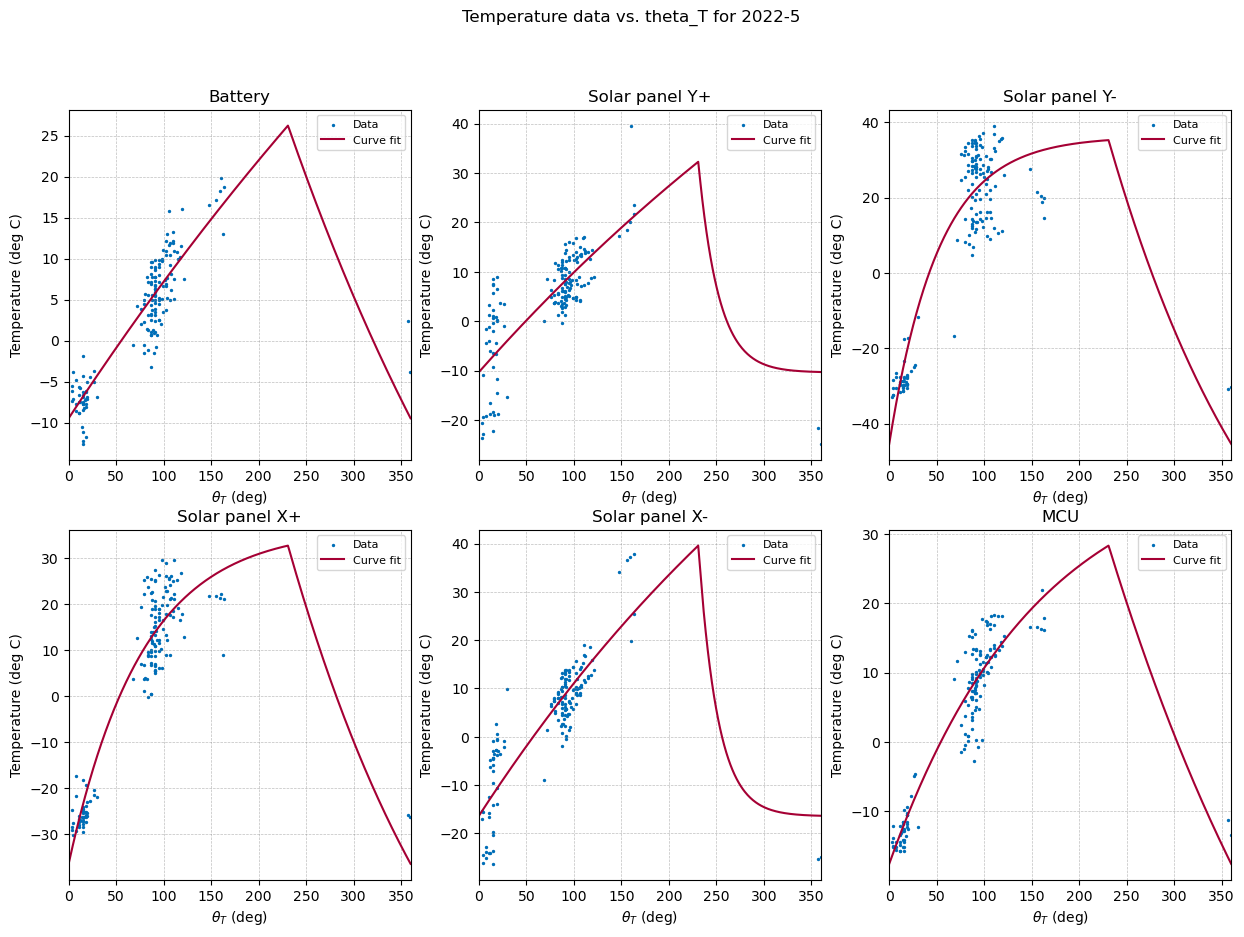

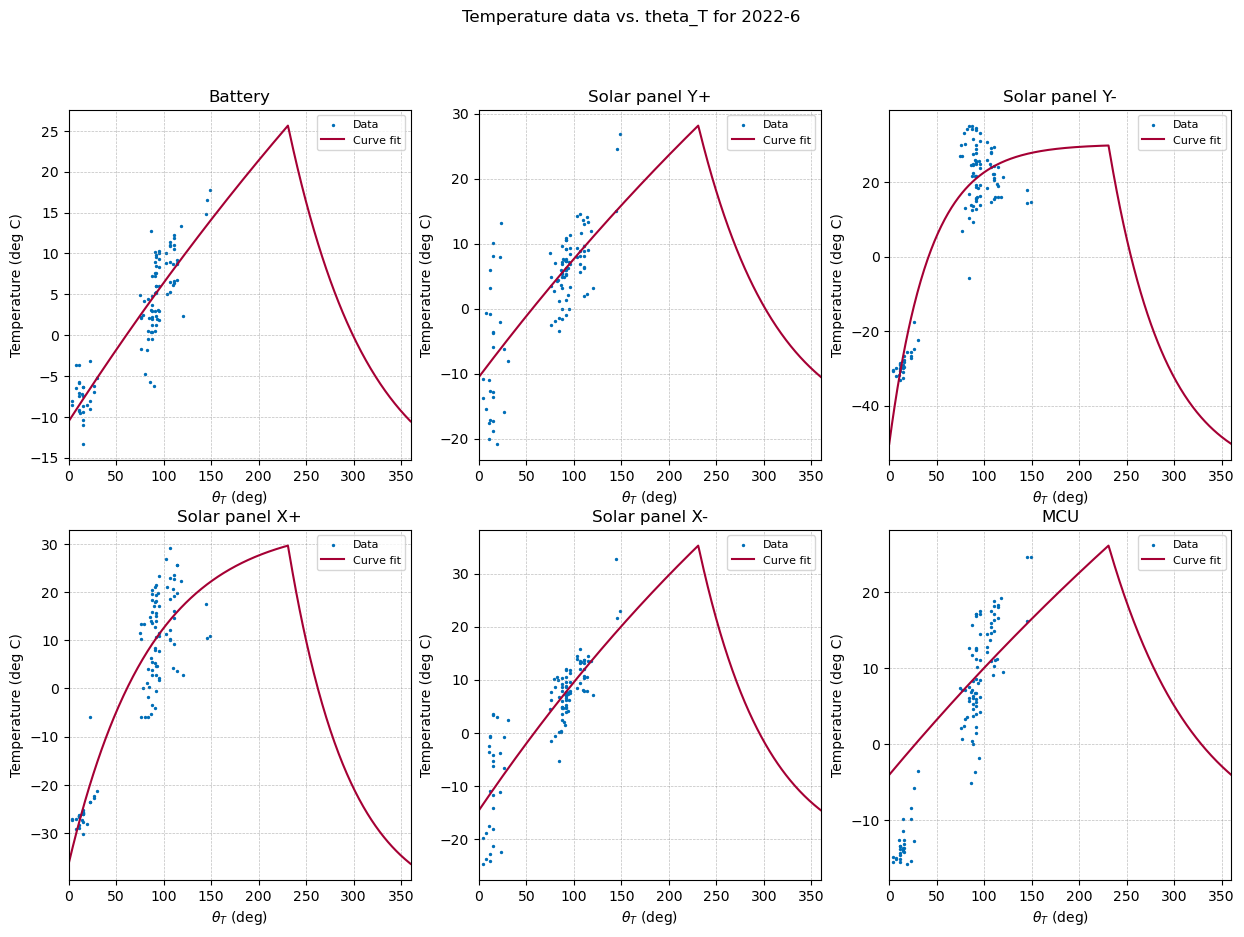

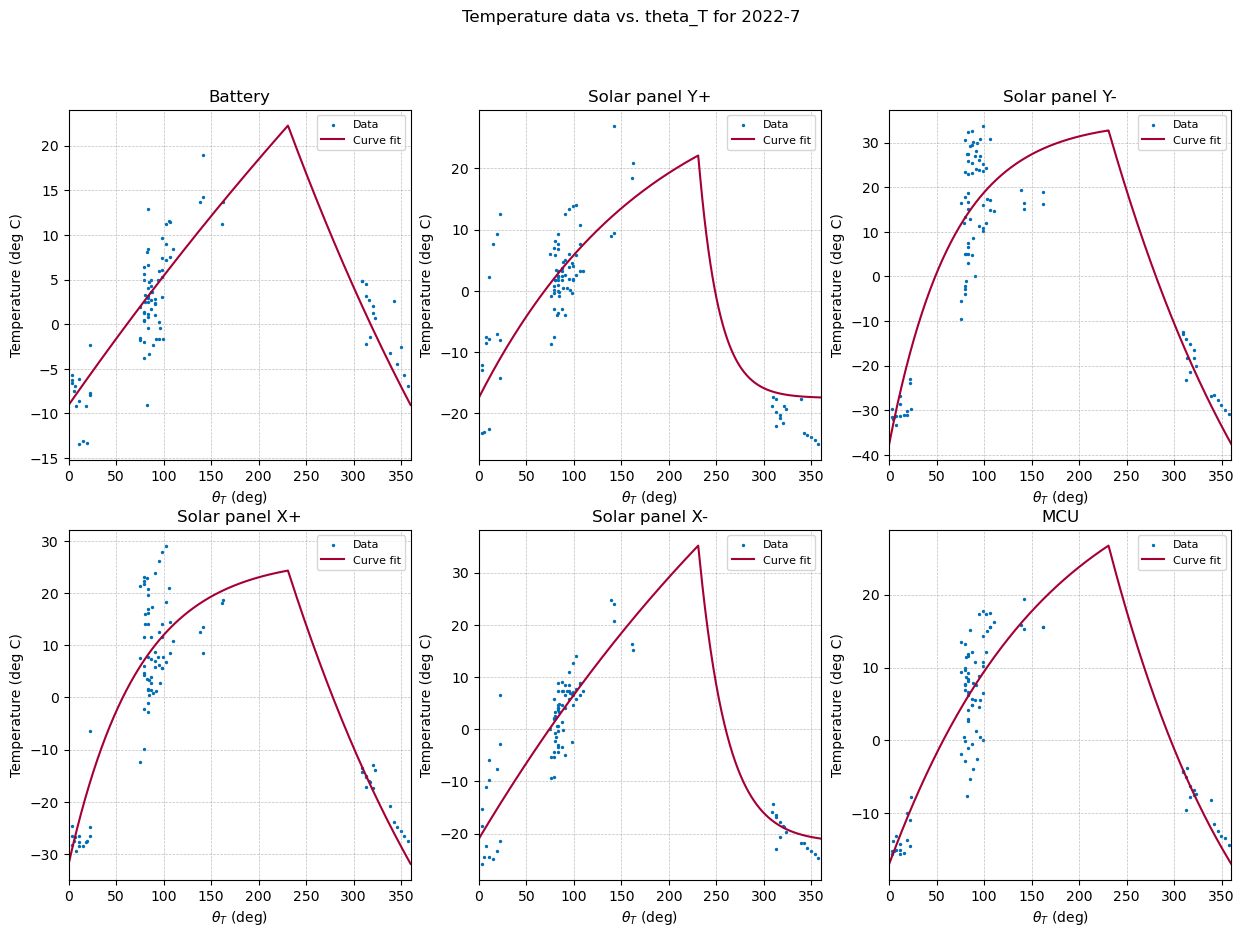

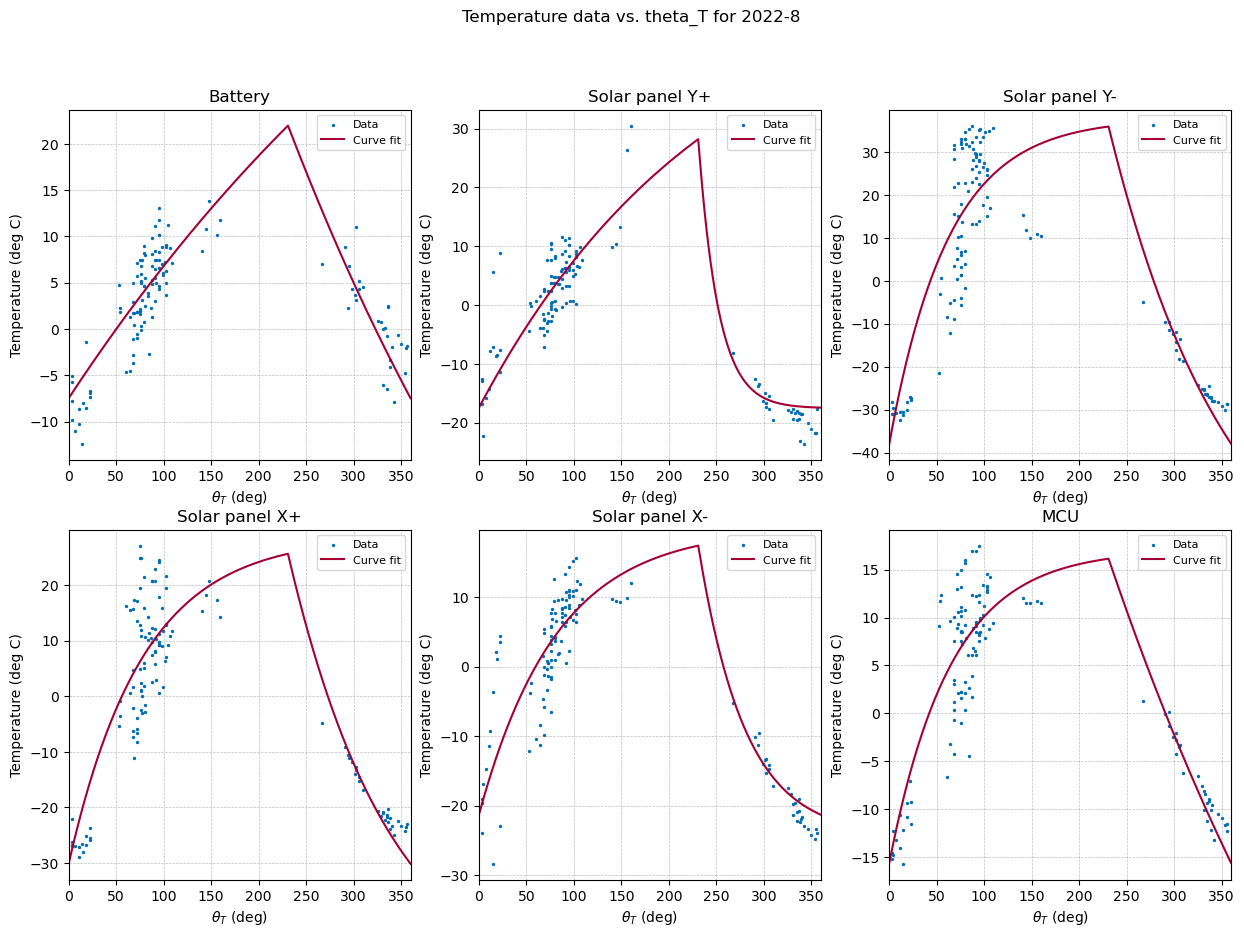

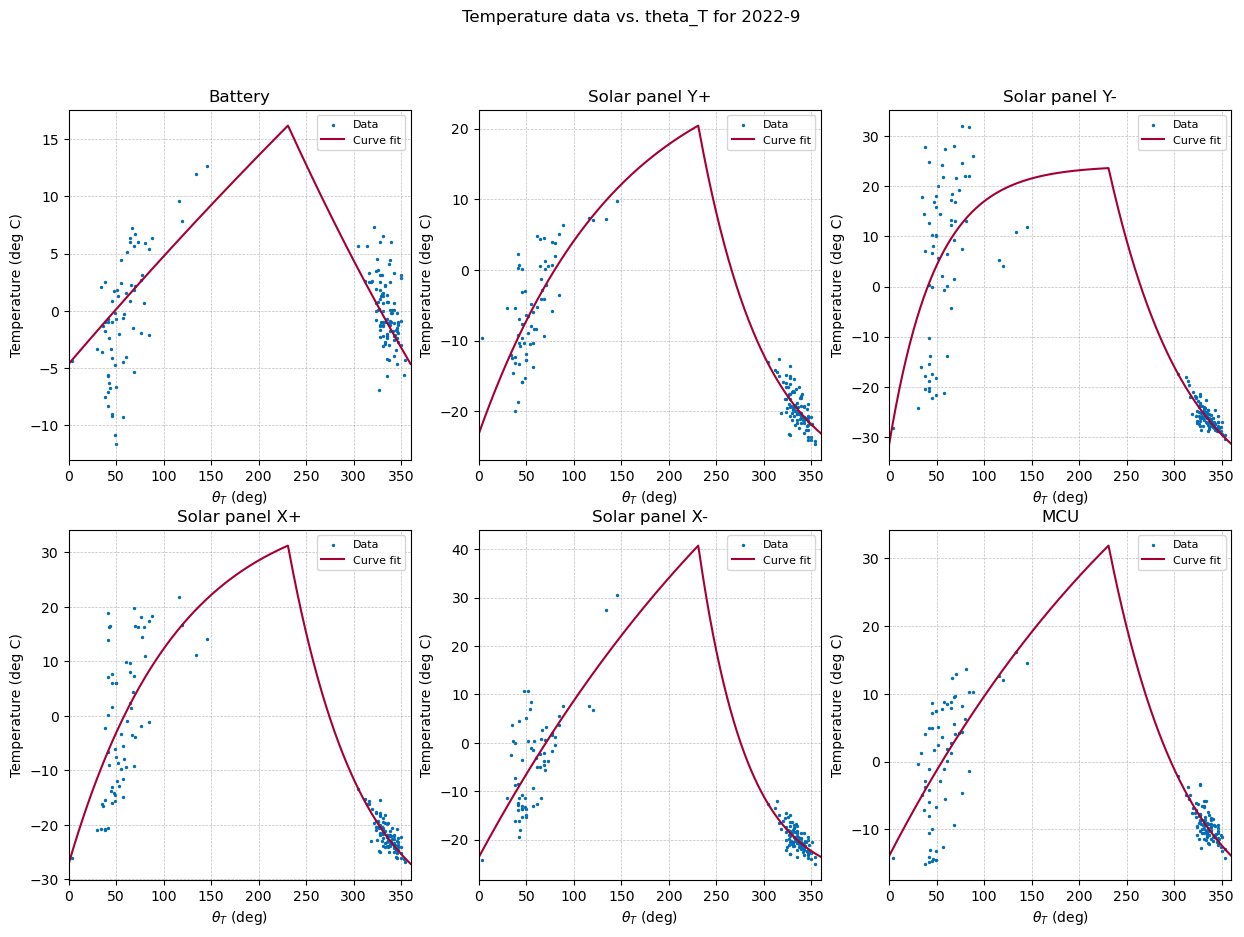

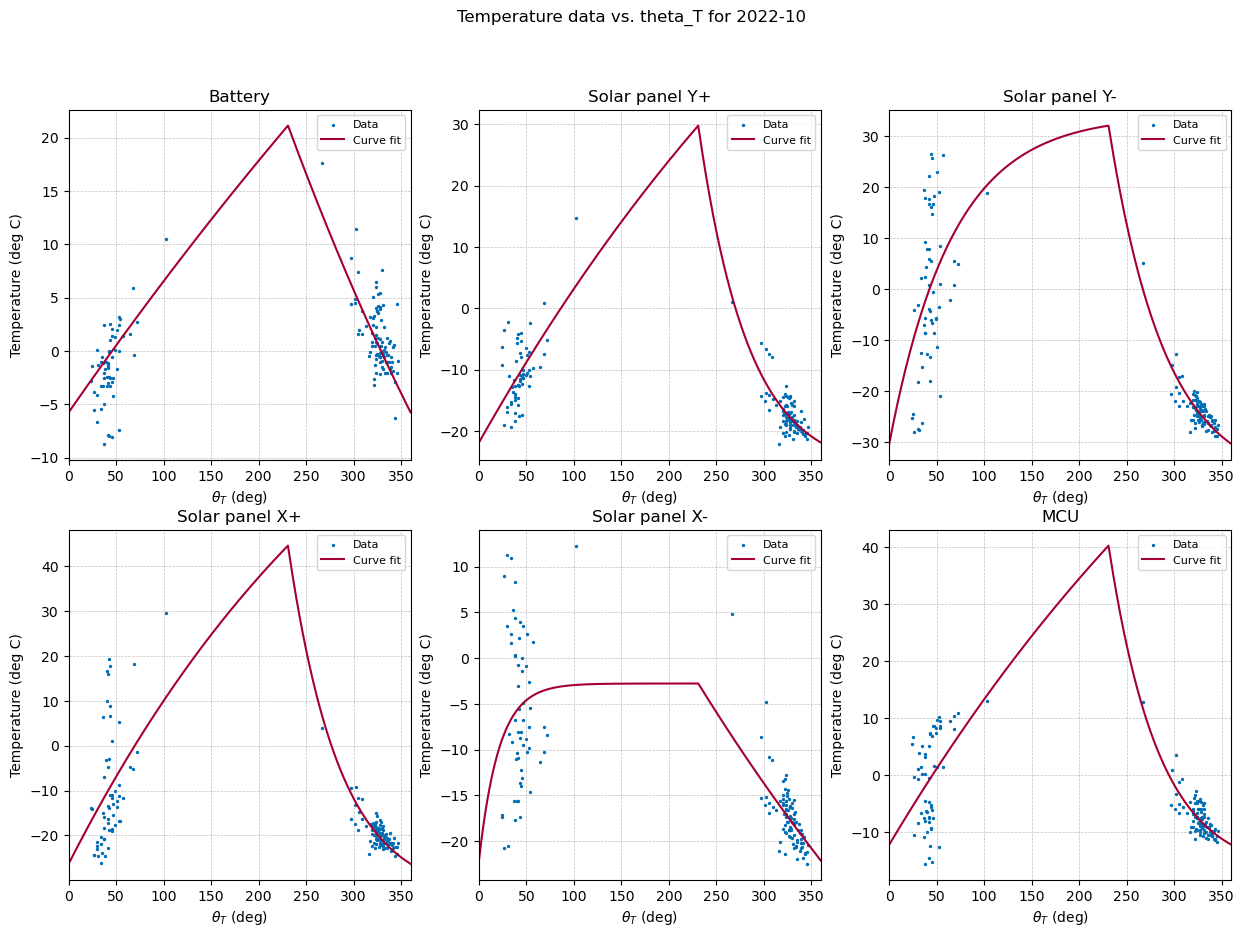

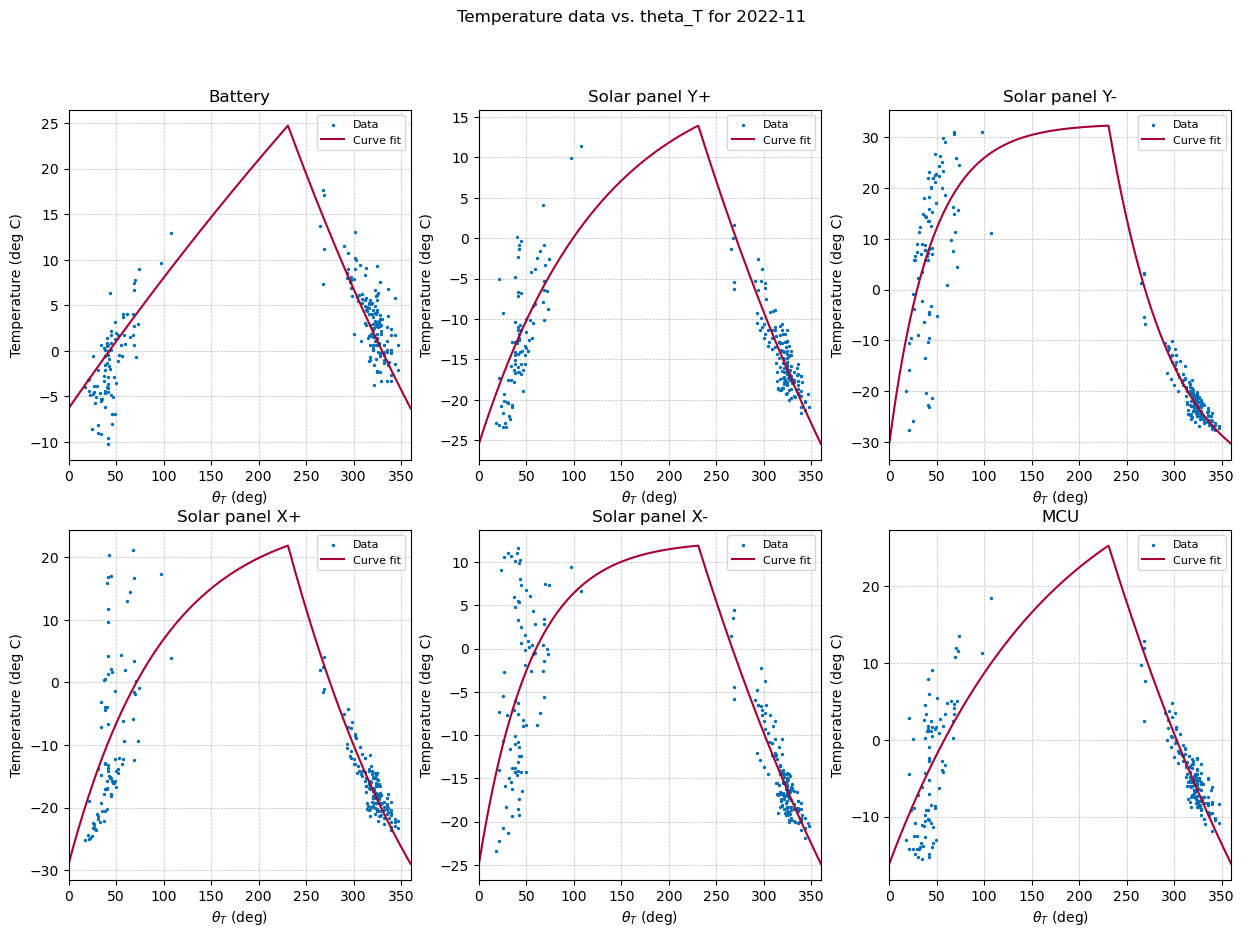

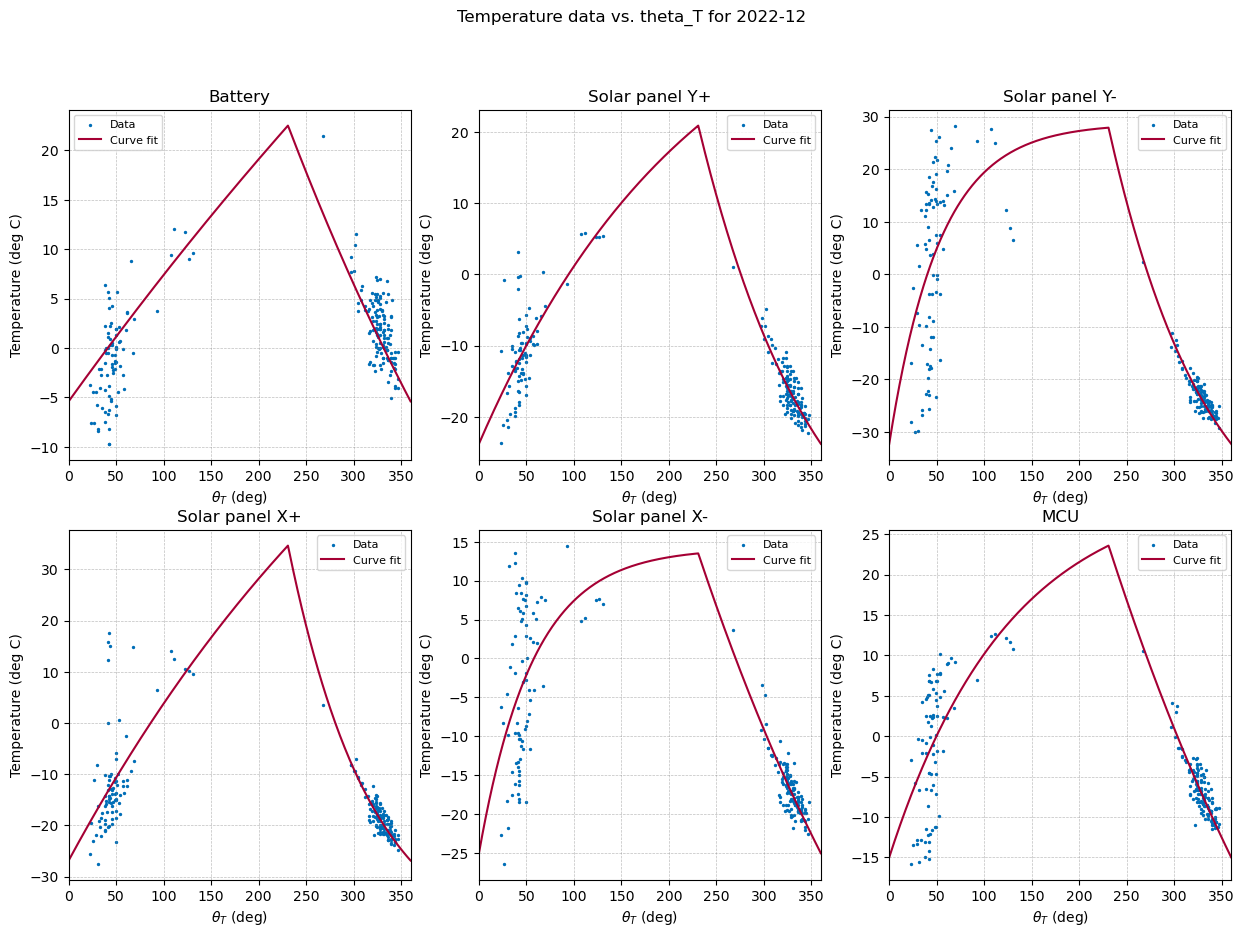

In [16]:
# Fitting the data for each month:
start_time = Time(telem_processed_df["time (utc)"][0], format="iso", scale="utc").to_datetime()
start_idx = 0

fit_params_month = np.empty(shape=(13, 6, 4), dtype=np.float64)
fit_errors = np.empty(shape=(13, 6), dtype=np.float64)
fit_month = 0

for i, row in telem_processed_df.iterrows():
    curr_time = Time(row["time (utc)"], format="iso", scale="utc").to_datetime()
    theta_T_fit = np.linspace(0, 360, 500)
    temp_fit = np.empty(shape=(theta_T_fit.shape[0], 6), dtype=np.float64)

    if curr_time.month != start_time.month:
        for j in range(6):
            theta_T_data = telem_processed_df["theta_T (deg)"][start_idx:i].to_numpy()
            temp_data = telem_processed_df.iloc[start_idx:i, -6+j].to_numpy()

            popt, pcov = curve_fit(
                fit_function,
                theta_T_data,
                temp_data + 273.15,
                p0=[25, 0.01, 300, 10],
                bounds=([0, 0, 200, 0.1], [150, 1, 350, 75]),
            )

            fit_params_month[fit_month, j] = popt

            temp_fit[:, j] = fit_function(theta_T_fit, *popt) - 273.15
            fit_errors[fit_month, j] = np.sqrt(np.mean((temp_data - fit_function(theta_T_data, *popt) + 273.15)**2))

        plot_model(
            [theta_T_data, theta_T_fit],
            [telem_processed_df.iloc[start_idx:i, -6:].to_numpy(), temp_fit],
            plt_titles=[
                "Battery",
                "Solar panel Y+",
                "Solar panel Y-",
                "Solar panel X+",
                "Solar panel X-",
                "MCU",
            ],
            labels=["Data", "Curve fit"],
            plt_scatter=[True, False],
            plt_suptitle=f"Temperature data vs. theta_T for {start_time.year}-{start_time.month}",
        )

        start_time = curr_time
        start_idx = i
        fit_month += 1

        

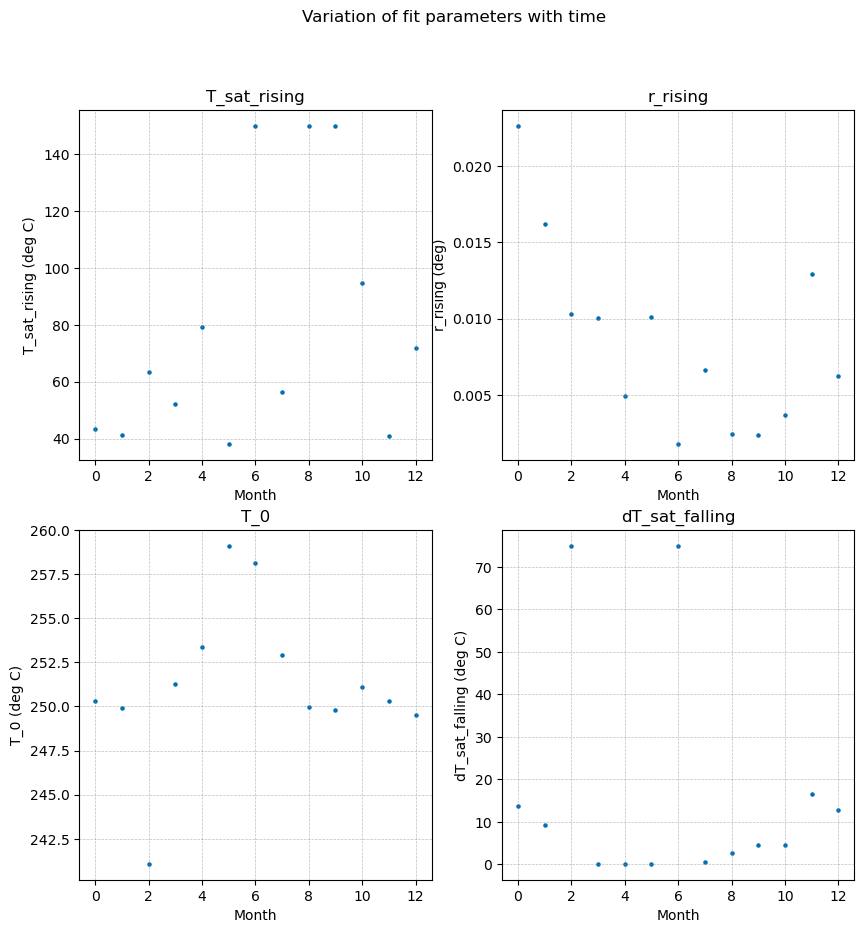

In [47]:
# Plotting the variation of the fit parameters for panel X- with time:
plt.figure(figsize=(10, 10))
plt.suptitle("Variation of fit parameters with time")
plt.subplot(2, 2, 1)
plt.scatter(
    np.arange(0, 13),
    fit_params_month[:, 4, 0],
    color=plt_colors[0],
    s=5
)
plt.title("T_sat_rising")
plt.xlabel("Month")
plt.ylabel("T_sat_rising (deg C)")
plt.grid()

plt.subplot(2, 2, 2)
plt.scatter(
    np.arange(0, 13),
    fit_params_month[:, 4, 1],
    color=plt_colors[0],
    s=5
)
plt.title("r_rising")
plt.xlabel("Month")
plt.ylabel("r_rising (deg)")
plt.grid()

plt.subplot(2, 2, 3)
plt.scatter(
    np.arange(0, 13),
    fit_params_month[:, 4, 2],
    color=plt_colors[0],
    s=5
)
plt.title("T_0")
plt.xlabel("Month")
plt.ylabel("T_0 (deg C)")
plt.grid()

plt.subplot(2, 2, 4)
plt.scatter(
    np.arange(0, 13),
    fit_params_month[:, 4, 3],
    color=plt_colors[0],
    s=5
)
plt.title("dT_sat_falling")
plt.xlabel("Month")
plt.ylabel("dT_sat_falling (deg C)")
plt.grid()

plt.show()



